In [1]:
from staudt_utils import print_eq
from astropy import units as u
from SHMpp import SHMpp_gvmin_reconcile as shmpp
import numpy as np
import pandas as pd
import pickle
import dm_den
import scipy
import fitting
import os

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import rcParams

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

In [3]:
def fr_f(vmag, sigma):
    f = (2.*np.pi*sigma**2.)**(-3./2.) * np.exp(-vmag**2./2./sigma**2.)
    return f
def fr3d_f(vmag, sigma):
    f = (3./(2.*np.pi*sigma**2.))**(3./2.) * np.exp(-3.*vmag**2./2./sigma**2.)
    return f
def fr3d_nonmax_f(vmag, sigma, a):
    e = np.exp(-(3.*vmag**2./2./sigma**2.)**a)
    N = 4. * scipy.special.gamma(1.+3./(2.*a)) / (3.*np.sqrt(np.pi))
    f = 1./N * (3./(2.*np.pi))**(3./2.) * 1./sigma**3. * e
    return f

In [8]:
def set_colors(ax,obj):
    ax.set_prop_cycle('color',[plt.cm.gist_ncar(i) 
                               for i in np.linspace(0., 
                                                    0.95, 
                                                    len(obj))][::-1])
    return None

In [6]:
with open('./data/v_pdfs_incl_ve_20220205.pkl','rb') as f:
#with open('./data/v_pdfs+ve_20220206.pkl','rb') as f:
    pdfs_v=pickle.load(f)
with open('./data/x_pdfs_20210823.pkl','rb') as f:
    pdfs_x=pickle.load(f)
with open('./data/vescs_20221222.pkl', 'rb') as f:
    vescs = pickle.load(f)

df_path = './data/'
df_fname = 'dm_den_202202140946.h5'
df = dm_den.load_data(df_fname)
#df = dm_den.load_data('dm_den_202202110933.h5')
sigmas = df['disp_dm_solar']
sigma_avg = sigmas.mean()
print_eq('\overline{\sigma}',sigma_avg)

<IPython.core.display.Latex object>

In [21]:
df['vesc_R0']=pd.Series({gal:vescs[gal]['ve_avg'] for gal in vescs})

In [22]:
with pd.HDFStore(df_path+df_fname) as store:
    store.put('data',df)
    store.get_storer('data').attrs.metadata={'dr':df.attrs['dr'],
                                             'drsolar':df.attrs['drsolar']}

In [23]:
def fr_forint(vmag, sigma, fr_f=fr3d_f):
    return fr_f(vmag, sigma) * 4.*np.pi*vmag**2.
scipy.integrate.quad(fr_forint, 0., np.inf, (sigma_avg))[0]

1.0000000000000002

In [24]:
def fr_nonmax_forint(vmag, sigma, a):
    fr_f=fr3d_nonmax_f
    return fr_f(vmag, sigma, a) * 4.*np.pi*vmag**2.
scipy.integrate.quad(fr_nonmax_forint, 0., np.inf, (sigma_avg, 2.))

(1.0000000000000013, 3.0042311321206317e-09)

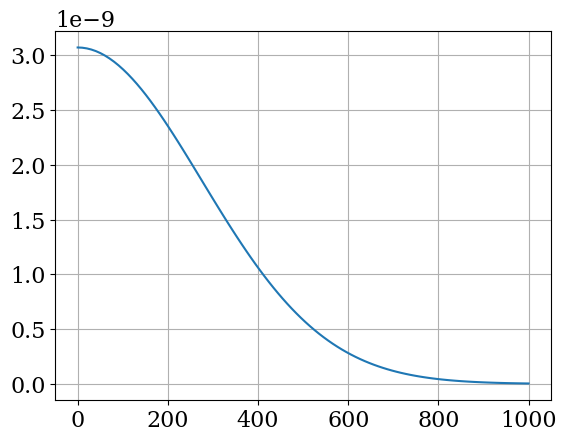

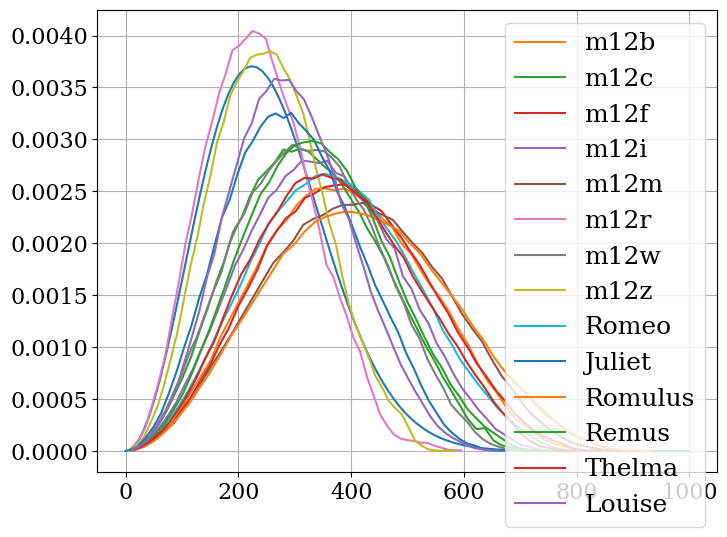

In [25]:
vmags_test=np.linspace(0.,1.e3,100)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(vmags_test, fr_f(vmags_test, sigma_avg))
plt.show()

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(vmags_test, fr_forint(vmags_test, sigma_avg))
for galname in pdfs_v:
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    ax.plot(midbins,pdfs_v[galname]['ps'],label=galname)
ax.legend()
plt.show()

<IPython.core.display.Latex object>

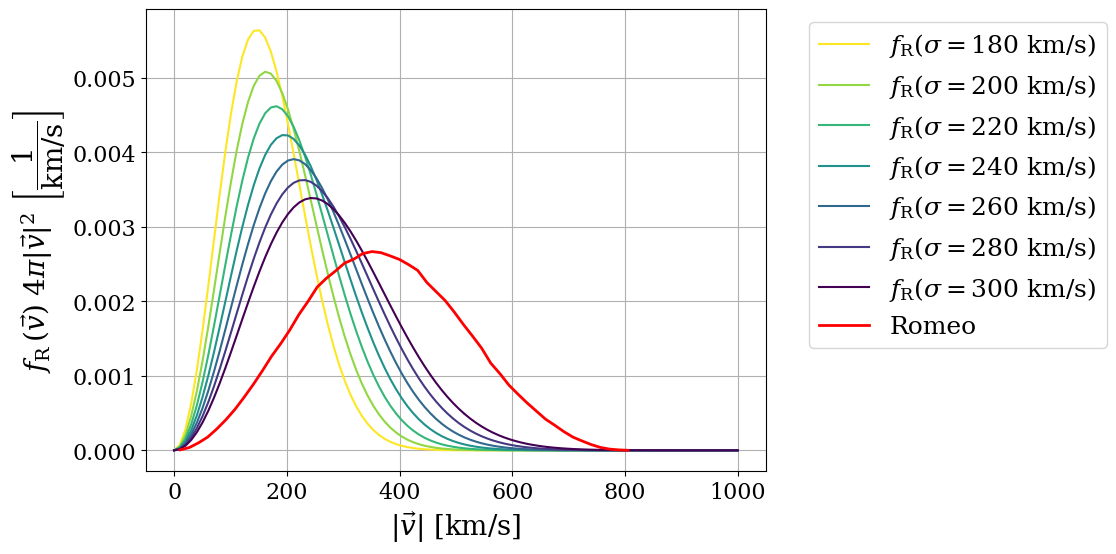

In [26]:
def plt_gal(galname, ax):
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    sigma = sigmas[galname]
    print_eq('\sigma(\mathrm{m12b})',sigma*u.km/u.s, 2)
    sigmas_test = np.linspace(180.,sigma,7)
    ax.set_prop_cycle('color',[plt.cm.viridis(i) 
                               for i in np.linspace(0, 
                                                    1, 
                                                    len(sigmas_test))][::-1])
    for sigma_test in sigmas_test:
        ax.plot(vmags_test, fr_forint(vmags_test, sigma_test, fr3d_f),
                label = '$f_\mathrm{{R}}(\sigma={0:0.0f}$ km/s)'.format(sigma_test))
    
    ax.plot(midbins,pdfs_v[galname]['ps'],'r-', lw=2., label=galname)
    return None

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
plt_gal('Romeo', ax)
ax.legend(bbox_to_anchor=(1.05,1.), loc='upper left')
ax.set_ylabel('$f_\mathrm{R}\,(\\vec{v})\ 4\pi|\\vec{v}|^2\ \\left[\dfrac{1}{\mathrm{km/s}}\\right]$')
ax.set_xlabel('$|\\vec{v}|\ [\mathrm{km/s}]$')
plt.show()

<font size="4">$f_\mathrm{R}\,(\vec{v})=\dfrac{1}{(2\pi)^{3/2}\sigma_\mathrm{iso}^3}\exp\left(-\dfrac{|\vec{v}|^2}{2\sigma_\mathrm{iso}^2}\right)$  
$\sigma_\mathrm{iso}=\sigma_\mathrm{3D}\big/\sqrt{3}$  
$\Rightarrow f_\mathrm{R}\,(\vec{v})=\left(\dfrac{3}{2\pi}\right)^{3/2}\dfrac{1}{\sigma_\mathrm{3D}^3}\exp\left(-\dfrac{3|\vec{v}|^2}{2\sigma_\mathrm{3D}^2}\right)$  
---  
$f_\mathrm{gen}\,(\vec{v})=\dfrac{1}{N}\left(\dfrac{3}{2\pi}\right)^{3/2}\dfrac{1}{\sigma_\mathrm{3D}^3}\exp\left(-\left(\dfrac{3|\vec{v}|^2}{2\sigma_\mathrm{3D}^2}\right)^\alpha\right)$  
$N=\dfrac{4\,\Gamma(1+\frac{3}{2\alpha})}{3\sqrt{\pi}}$</font>

# Testing my fitting module

In [27]:
import importlib
importlib.reload(fitting)

<module 'fitting' from '/Users/patrick/dm_den/fitting.py'>

In [28]:
pdfs_v_forfitdimgal = {}
for galname in pdfs_v:
    pdfs_v_forfitdimgal[galname]={}
    pdfs_v_forfitdimgal[galname]['mag']={}
    pdfs_v_forfitdimgal[galname]['mag']['bins']=pdfs_v[galname]['bins']
    pdfs_v_forfitdimgal[galname]['mag']['ps']=pdfs_v[galname]['ps']

/Users/patrick/dm_den/fitting.py:5: RuntimeWarning: invalid value encountered in power
  f = 4.*np.pi*v**2.*np.exp(-(v/v0)**(2.*a))
/Users/patrick/miniconda3/envs/dm_stats/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/patrick/dm_den/fitting.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.step(xs,ys,'k',where='mid',color='grey')


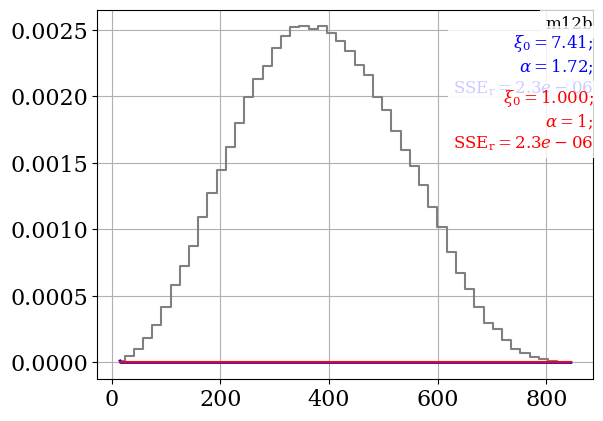

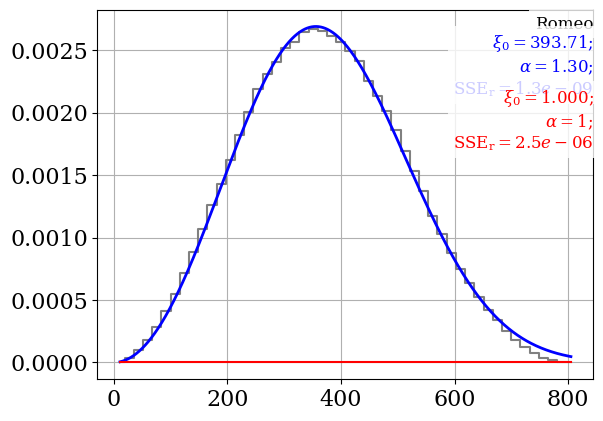

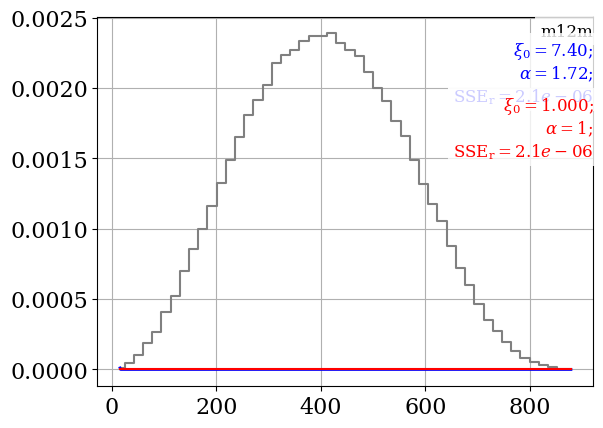

In [29]:
for galname in ['m12b','Romeo','m12m']:
    fig=plt.figure()
    ax=fig.add_subplot(111)
    fitting.fit_dim_gal(galname, 'mag', pdfs_v_forfitdimgal, ax)

# Fitting from scratch

In [30]:
def fit(galname):
    pdf = pdfs_v[galname]
    bins = pdf['bins']
    vs = (bins[1:]+bins[:-1])/2.
    ps = pdf['ps']
    res=scipy.optimize.curve_fit(fr_nonmax_forint, vs, ps, p0=[250.,1.])
    return res

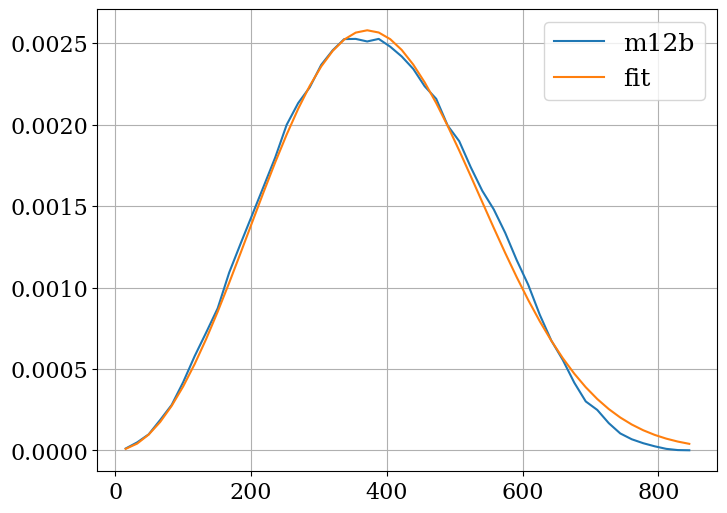

(503.5237882720582, 1.3058237565331525)

In [31]:
def test_fit(galname):
    sigma_fit, a = fit(galname)[0]
    
    pdf = pdfs_v[galname]
    bins = pdf['bins']
    vs = (bins[1:]+bins[:-1])/2.
    ps = pdf['ps']
    
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    ax.plot(vs,ps, label=galname)
    ax.plot(vs,fr_nonmax_forint(vs, sigma_fit, a), label='fit')
    ax.legend()
    plt.show()

    return sigma_fit, a
test_fit('m12b')

# Plotting $g$

## This one is old:

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


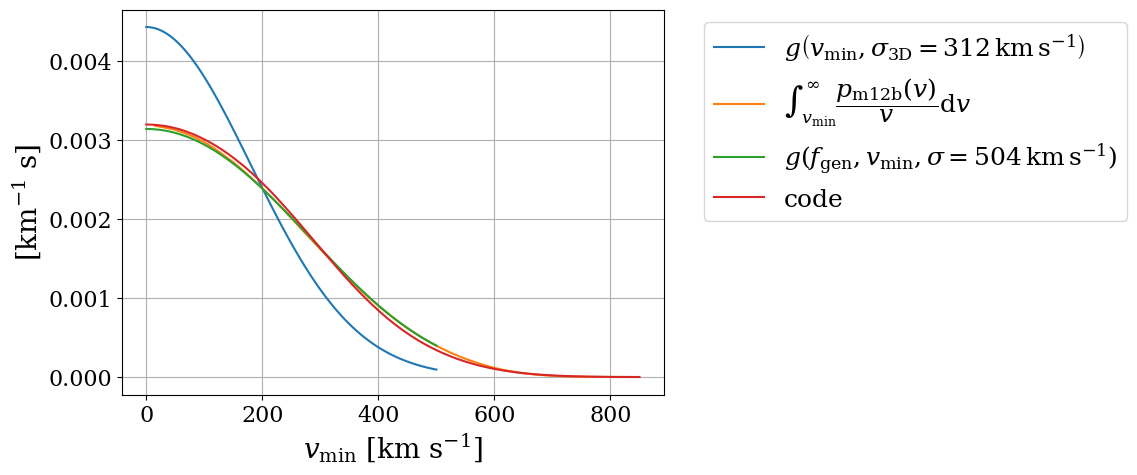

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


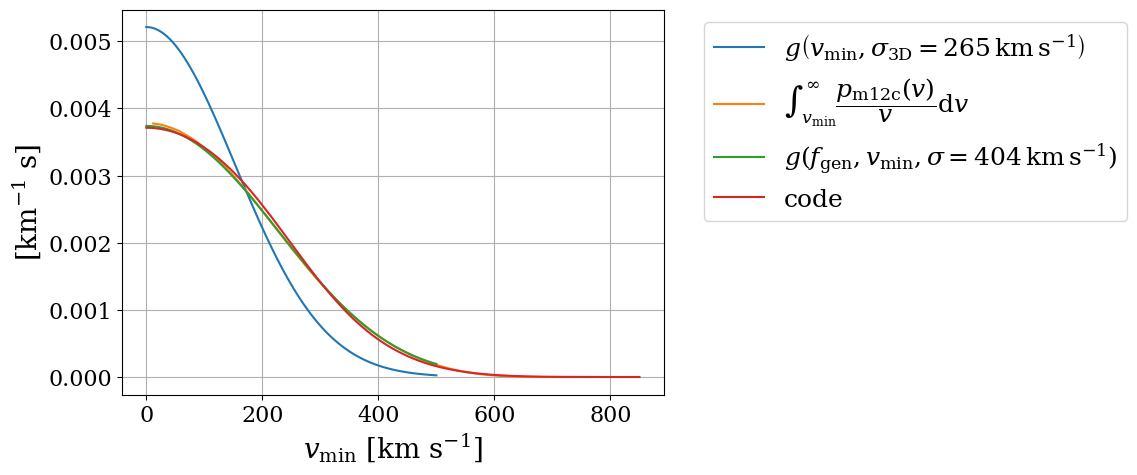

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


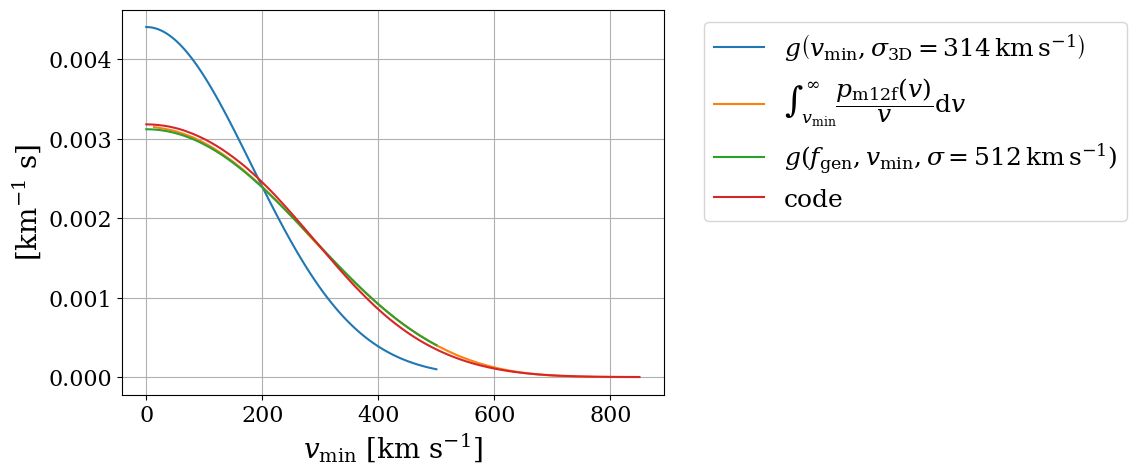

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


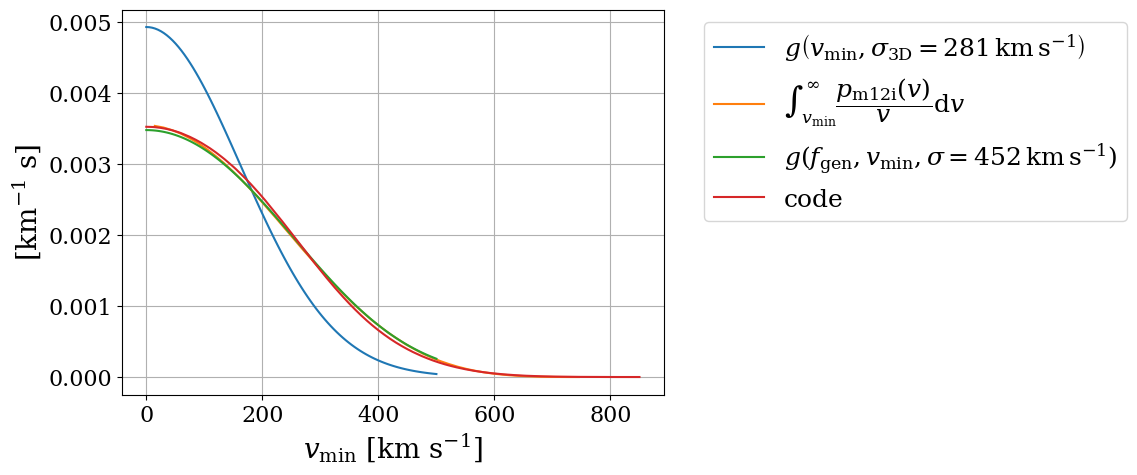

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


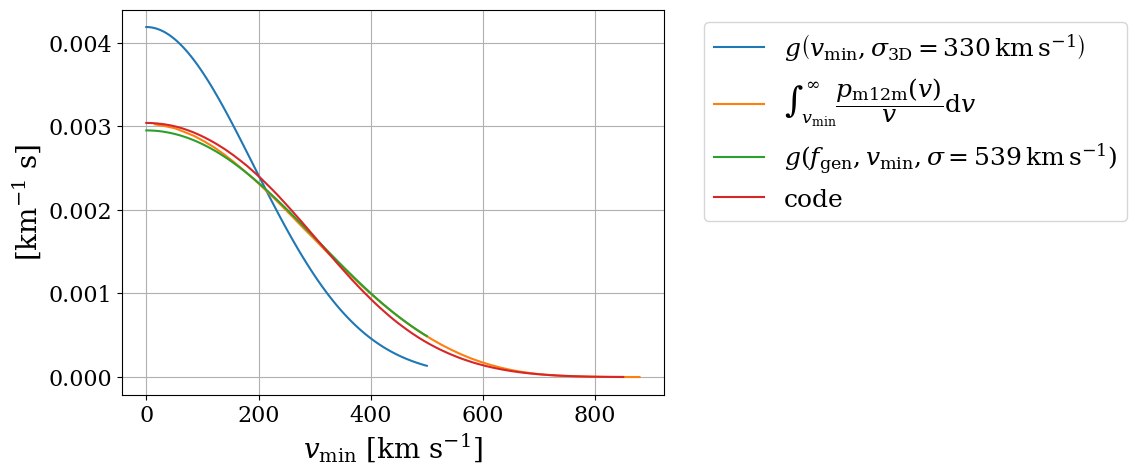

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


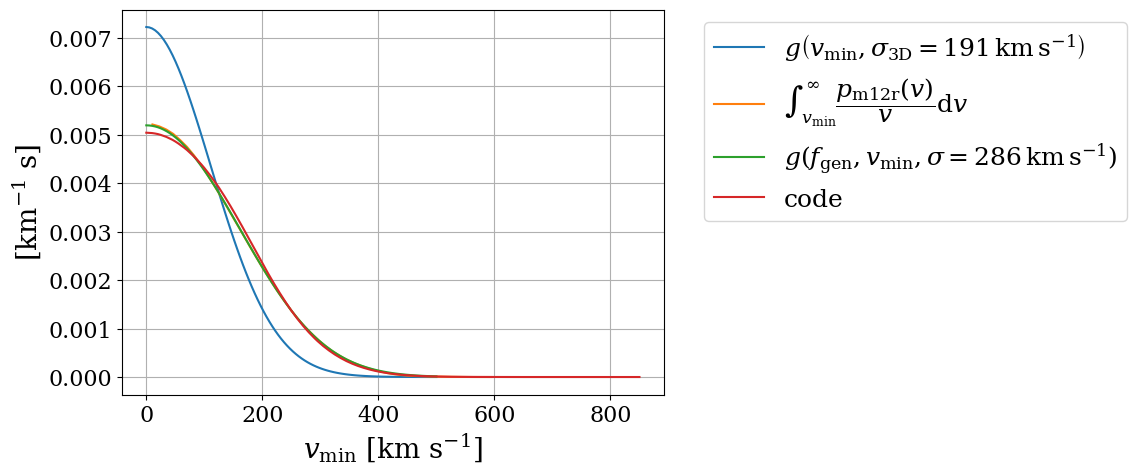

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


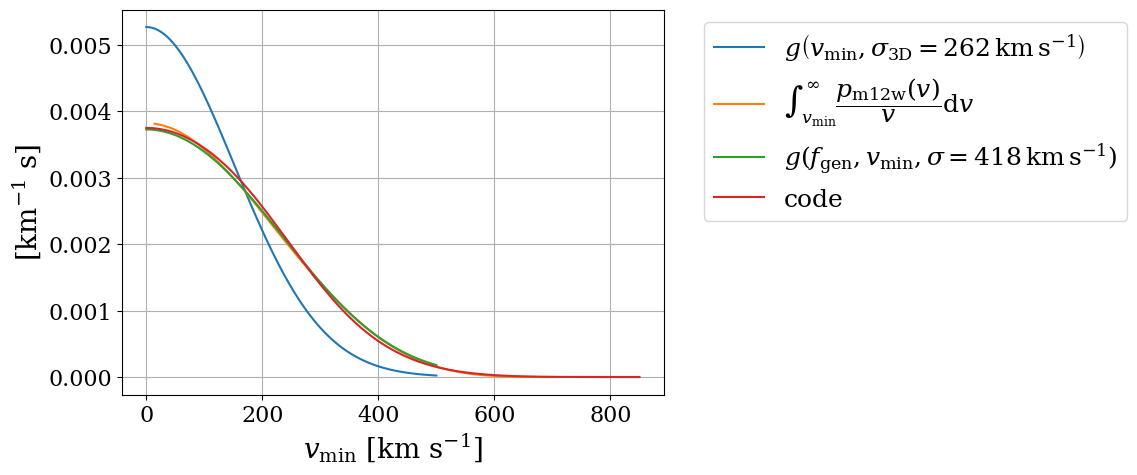

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


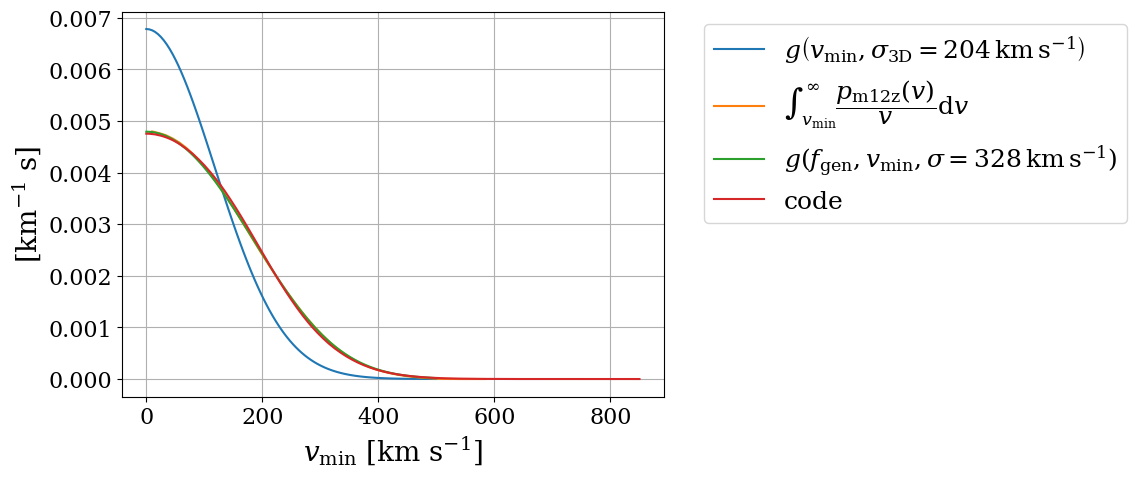

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


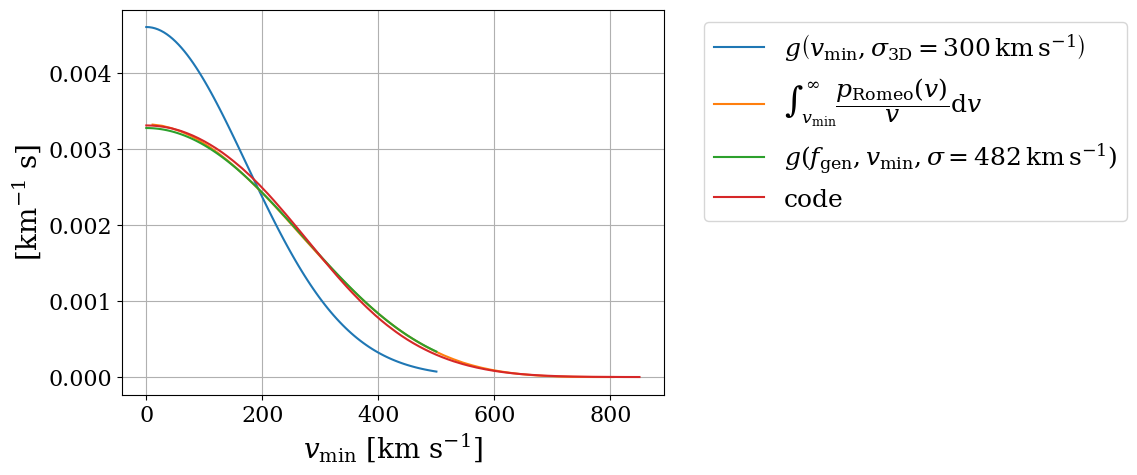

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


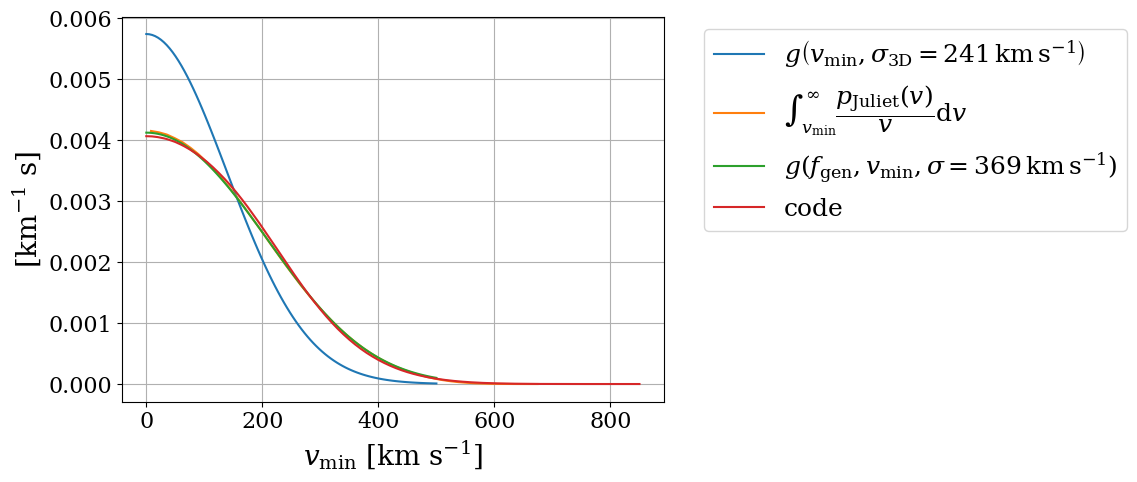

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


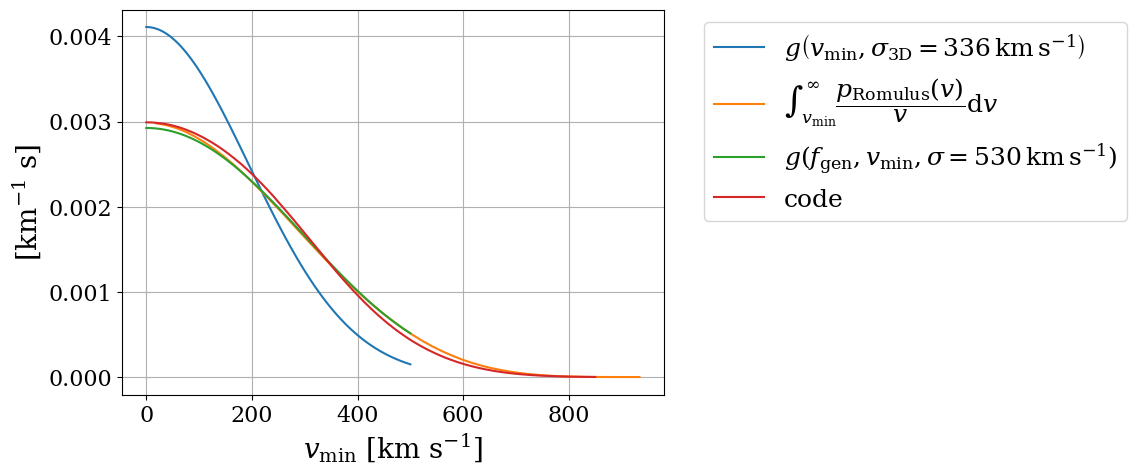

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


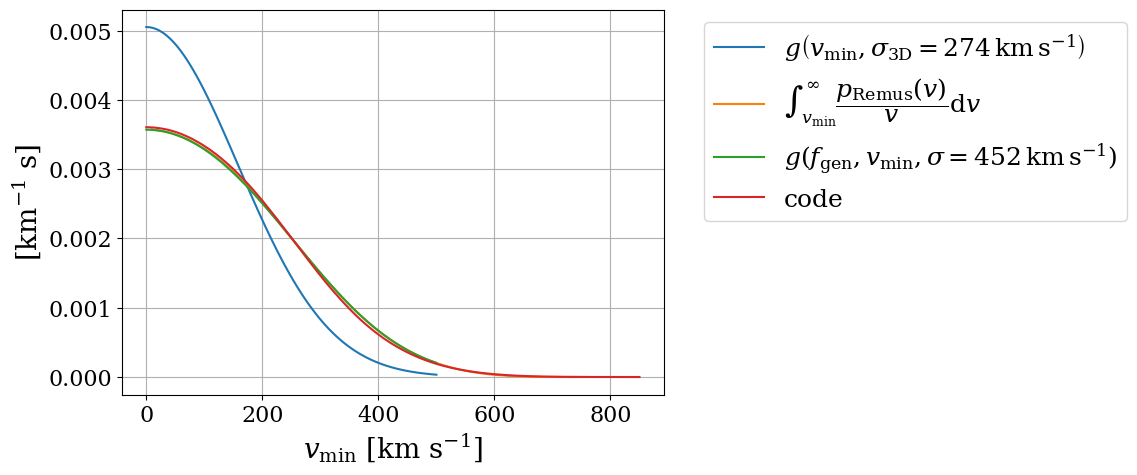

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


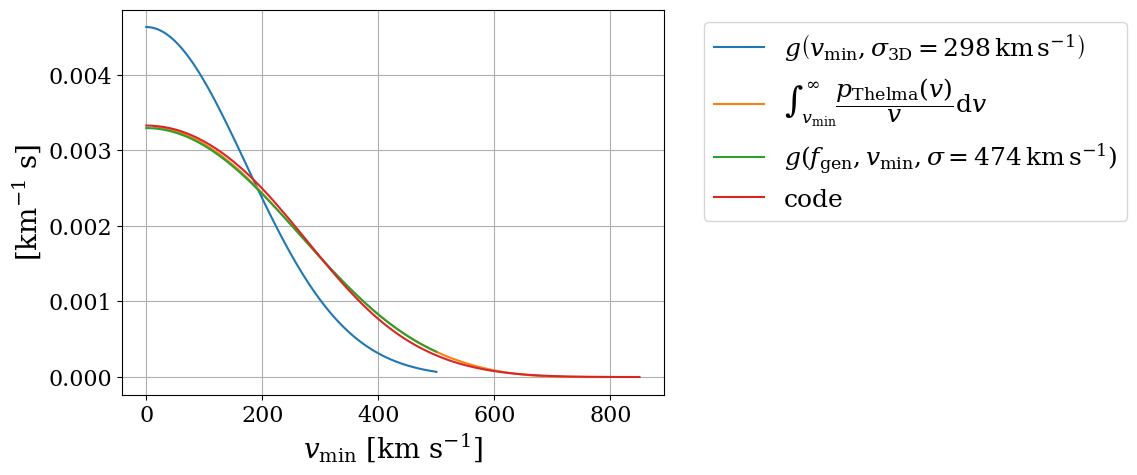

Calculating gvmin for SHM++ ( with eta= 0.2 )

Calculating gvmin for Round component

Calculating gvmin for Sausage component


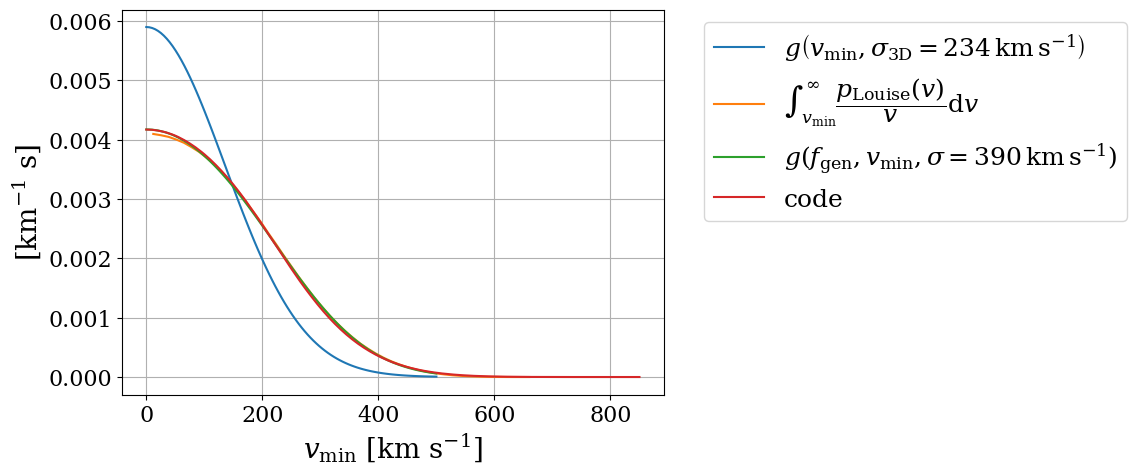

In [32]:
def evans_compare(galname):
    vbins=pdfs_v[galname]['bins']
    dvs=vbins[1:]-vbins[:-1]
    dv = np.mean(dvs)
    ps=pdfs_v[galname]['ps']
    vs=(vbins[1:]+vbins[:-1])/2.
    
    # p(vmin) = 4pi v^2 f(v)
    # g(vmin) = int f(v)/v (4pi v^2 dv) 
    #         = int p(v) / (4pi v^2) v^2/v 4pi dv
    #         = int p(v)/v dv
    integrand =  ps / vs
    g_num = [scipy.integrate.simps(integrand[i:],vs[i:]) 
             for i in range(len(integrand))]

    def g_integrand(v, sigma):
        return 4.*np.pi*v**2. * fr3d_f(v, sigma)/v
    def g_f(vmin, sigma):
        return scipy.integrate.quad(g_integrand, vmin, np.inf, (sigma))[0]   
    def myg_integrand(v, sigma, a):
        return 4.*np.pi*v**2. * fr3d_nonmax_f(v, sigma, a)/v
    def myg_f(vmin, sigma, a):
        return scipy.integrate.quad(myg_integrand, vmin, np.inf, (sigma, a))[0]

    fig=plt.figure(figsize=(7,5))
    ax=fig.add_subplot(111)
    sigma=sigmas[galname]
    
    vmags_test=np.linspace(0.,5.e2,100)
    ax.plot(vmags_test, [g_f(v, sigma) for v in vmags_test],
            label='$g\\left(v_\mathrm{{min}},\sigma_\mathrm{{3D}}={{{0:0.0f}}}'
                  '\,\mathrm{{km}}\,\mathrm{{s}}^{{-1}}\\right)$'.format(sigma))
    ax.plot(vs, g_num, 
            label='$\int_{{v_\mathrm{{min}}}}^\infty'
                  '\\dfrac{{p_\mathrm{{{0}}}(v)}}'
                  '{{v}}\mathrm{{d}}v$'.format(galname))
    
    sigma_fit, a = fit(galname)[0]
    ax.plot(vmags_test, [myg_f(v, sigma_fit, a) for v in vmags_test],
            label='$g(f_\mathrm{{gen}}, v_\mathrm{{min}}, \sigma={0:0.0f}'
                  '\,\mathrm{{km}}\,\mathrm{{s}}^{{-1}})$'.format(sigma_fit))
    
    ############################################################################
    v0 = sigma*np.sqrt(2.)/np.sqrt(3.)
    ############################################################################
    ax.plot(*shmpp.gen_shmpp(v0,600.),label='code')
    ############################################################################
    ax.set_xlabel('$v_\mathrm{min}$ [km s$^{-1}$]')
    ax.set_ylabel('[km$^{-1}$ s]')
    ax.legend(bbox_to_anchor=(1.05,1.), loc='upper left')
    fig.patch.set_facecolor('white')

    plt.show()

    return None

for gal in pdfs_v:
    evans_compare(gal)

## This is my current work:

In [33]:
from importlib import reload
reload(shmpp)

<module 'SHMpp.SHMpp_gvmin_reconcile' from '/Users/patrick/dm_den/SHMpp/SHMpp_gvmin_reconcile.py'>

In [8]:
def evans_compare(ax, galname, incl_v_esc=True, v_esc_mult=1., normalize=False):
    vbins=pdfs_v[galname]['bins']
    dvs=vbins[1:]-vbins[:-1]
    dv = np.mean(dvs)
    ps=pdfs_v[galname]['ps']
    vs=(vbins[1:]+vbins[:-1])/2.

    # p(vmin) = 4pi v^2 f(v)
    # g(vmin) = int f(v)/v (4pi v^2 dv) 
    #         = int p(v) / (4pi v^2) v^2/v 4pi dv
    #         = int p(v)/v dv
    integrand =  ps / vs
    g_num = [scipy.integrate.simps(integrand[i:],vs[i:]) 
             for i in range(len(integrand))]
    g_num = np.array(g_num)

    '''
    # These never get used. Consider deleting the code
    def g_integrand(v, sigma):
        return 4.*np.pi*v**2. * fr3d_f(v, sigma)/v
    def g_f(vmin, sigma):
        return scipy.integrate.quad(g_integrand, vmin, np.inf, (sigma))[0]
    
    def myg_integrand(v, sigma, a):
        return 4.*np.pi*v**2. * fr3d_nonmax_f(v, sigma, a)/v
    def myg_f(vmin, sigma, a):
        return scipy.integrate.quad(myg_integrand, vmin, np.inf, (sigma, a))[0]
    '''

    sigma=sigmas[galname]
    
    #sigma_fit, a = fit(galname)[0]
    #ax.plot(vmags_test, [myg_f(v, sigma_fit, a) for v in vmags_test],
    #        label='$g(f_\mathrm{{gen}}, v_\mathrm{{min}}, \sigma={0:0.0f}'
    #              '\,\mathrm{{km}}\,\mathrm{{s}}^{{-1}})$'.format(sigma_fit))
    
    #Perform SHM calculations:
    if incl_v_esc:
        vesc=df.loc[galname,'vesc_R0'] * v_esc_mult
    else:
        vesc=np.inf
    ############################################################################
    v0 = sigma*np.sqrt(2.)/np.sqrt(3.)
    ############################################################################
    #ax.plot(*shmpp.gen_shmpp(v0,vesc),
    #        label='SHM$^{{++}}(\sigma_\mathrm{{3D}}={0:0.0f}'
    #              '\,\mathrm{{km}}\,\mathrm{{s}}^{{-1}})$'.format(sigma))
    ############################################################################
    vs_shm, gs_shm = shmpp.gen_round(v0, vesc, verbose=False)

    if normalize:
        xs_sim = vs/sigma
        xs_shm = vs_shm/sigma 
        #ax.set_xlabel('$v_\mathrm{min}/\sigma_\mathrm{3D}$')
    else:
        xs_sim = vs
        xs_shm = vs_shm
        #ax.set_xlabel('$v_\mathrm{min}$ [km s$^{-1}$]')
    
    ax.plot(xs_sim, g_num, 
            label='true $g(v_\mathrm{min})$',
            c='k', lw=3.)
    if incl_v_esc:
        if v_esc_mult == 1.:
            shm_label = 'SHM$(\mathrm{true}\,\sigma_\mathrm{{3D}}$'\
                        ',\n        '\
                        'true$\,v_\mathrm{{esc}})$'
        else:
            shm_label = 'SHM$(\mathrm{{true}}\,\sigma_\mathrm{{3D}}$'\
                        ',\n        '\
                        '${0:0.1f}\,\mathrm{{true}}\,v_\mathrm{{esc}})$'\
                        .format(v_esc_mult)
    else:
        shm_label = 'SHM$(\mathrm{true}\,\sigma_\mathrm{{3D}}$'\
                    ',\n        '\
                    '$v_\mathrm{esc}=\infty)$'        
    ax.plot(xs_shm, gs_shm,
            label=shm_label, c='red')
    ############################################################################

    #Calculating deltas
    g_shm_f = lambda v: np.interp(v, vs_shm, gs_shm)
    #SHM g interpolated and evaluated at the vs from the simulation PDFs:
    g_shm_vs = g_shm_f(vs)
    deltas = g_shm_vs - g_num 
    frac_deltas = deltas/g_num
    
    #"attempt" to normalize by 3D velocity dispersion
    return vs/sigma, deltas, frac_deltas, g_num, g_shm_vs

def gen_deltas(incl_v_esc=True, v_esc_mult=1., norm_plots=False):
    deltas = {}
    
    fig,axs=plt.subplots(3, 4, figsize=(19.,12.), sharey='row',
                         sharex=True, dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')
    for i, gal in enumerate(pdfs):
        deltas[gal] = {}
        res = evans_compare(axs[i], gal, incl_v_esc, v_esc_mult, 
                            normalize=norm_plots)
        deltas[gal]['zetas'] = res[0]
        deltas[gal]['deltas'] = res[1]
        deltas[gal]['deltas_frac'] = res[2]
        deltas[gal]['g_sim'] = res[3]
        deltas[gal]['g_shm'] = res[4]
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        axs[i].grid(False)
        axs[i].set_yscale('log')
    for i in [0,4,8]:
        axs[i].set_ylabel('[km$^{-1}$ s]')
    for ax in axs[-4:]:
        if norm_plots:
            ax.set_xlabel('$v_\mathrm{min}/\sigma_\mathrm{3D}$')
        else:
            ax.set_xlabel('$v_\mathrm{min}$ [km s$^{-1}$]')
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.04),
                   bbox_transform=fig.transFigure, ncol=3)
    fig.suptitle('Adjusted for Earth\'s velocity', fontsize=20., y=0.91)
    plt.show()
    return deltas

/var/folders/94/r7q1ltfd5cdf55qhtt067d380000gn/T/ipykernel_14014/556659488.py:87: RuntimeWarning: divide by zero encountered in true_divide
  frac_deltas = deltas/g_num


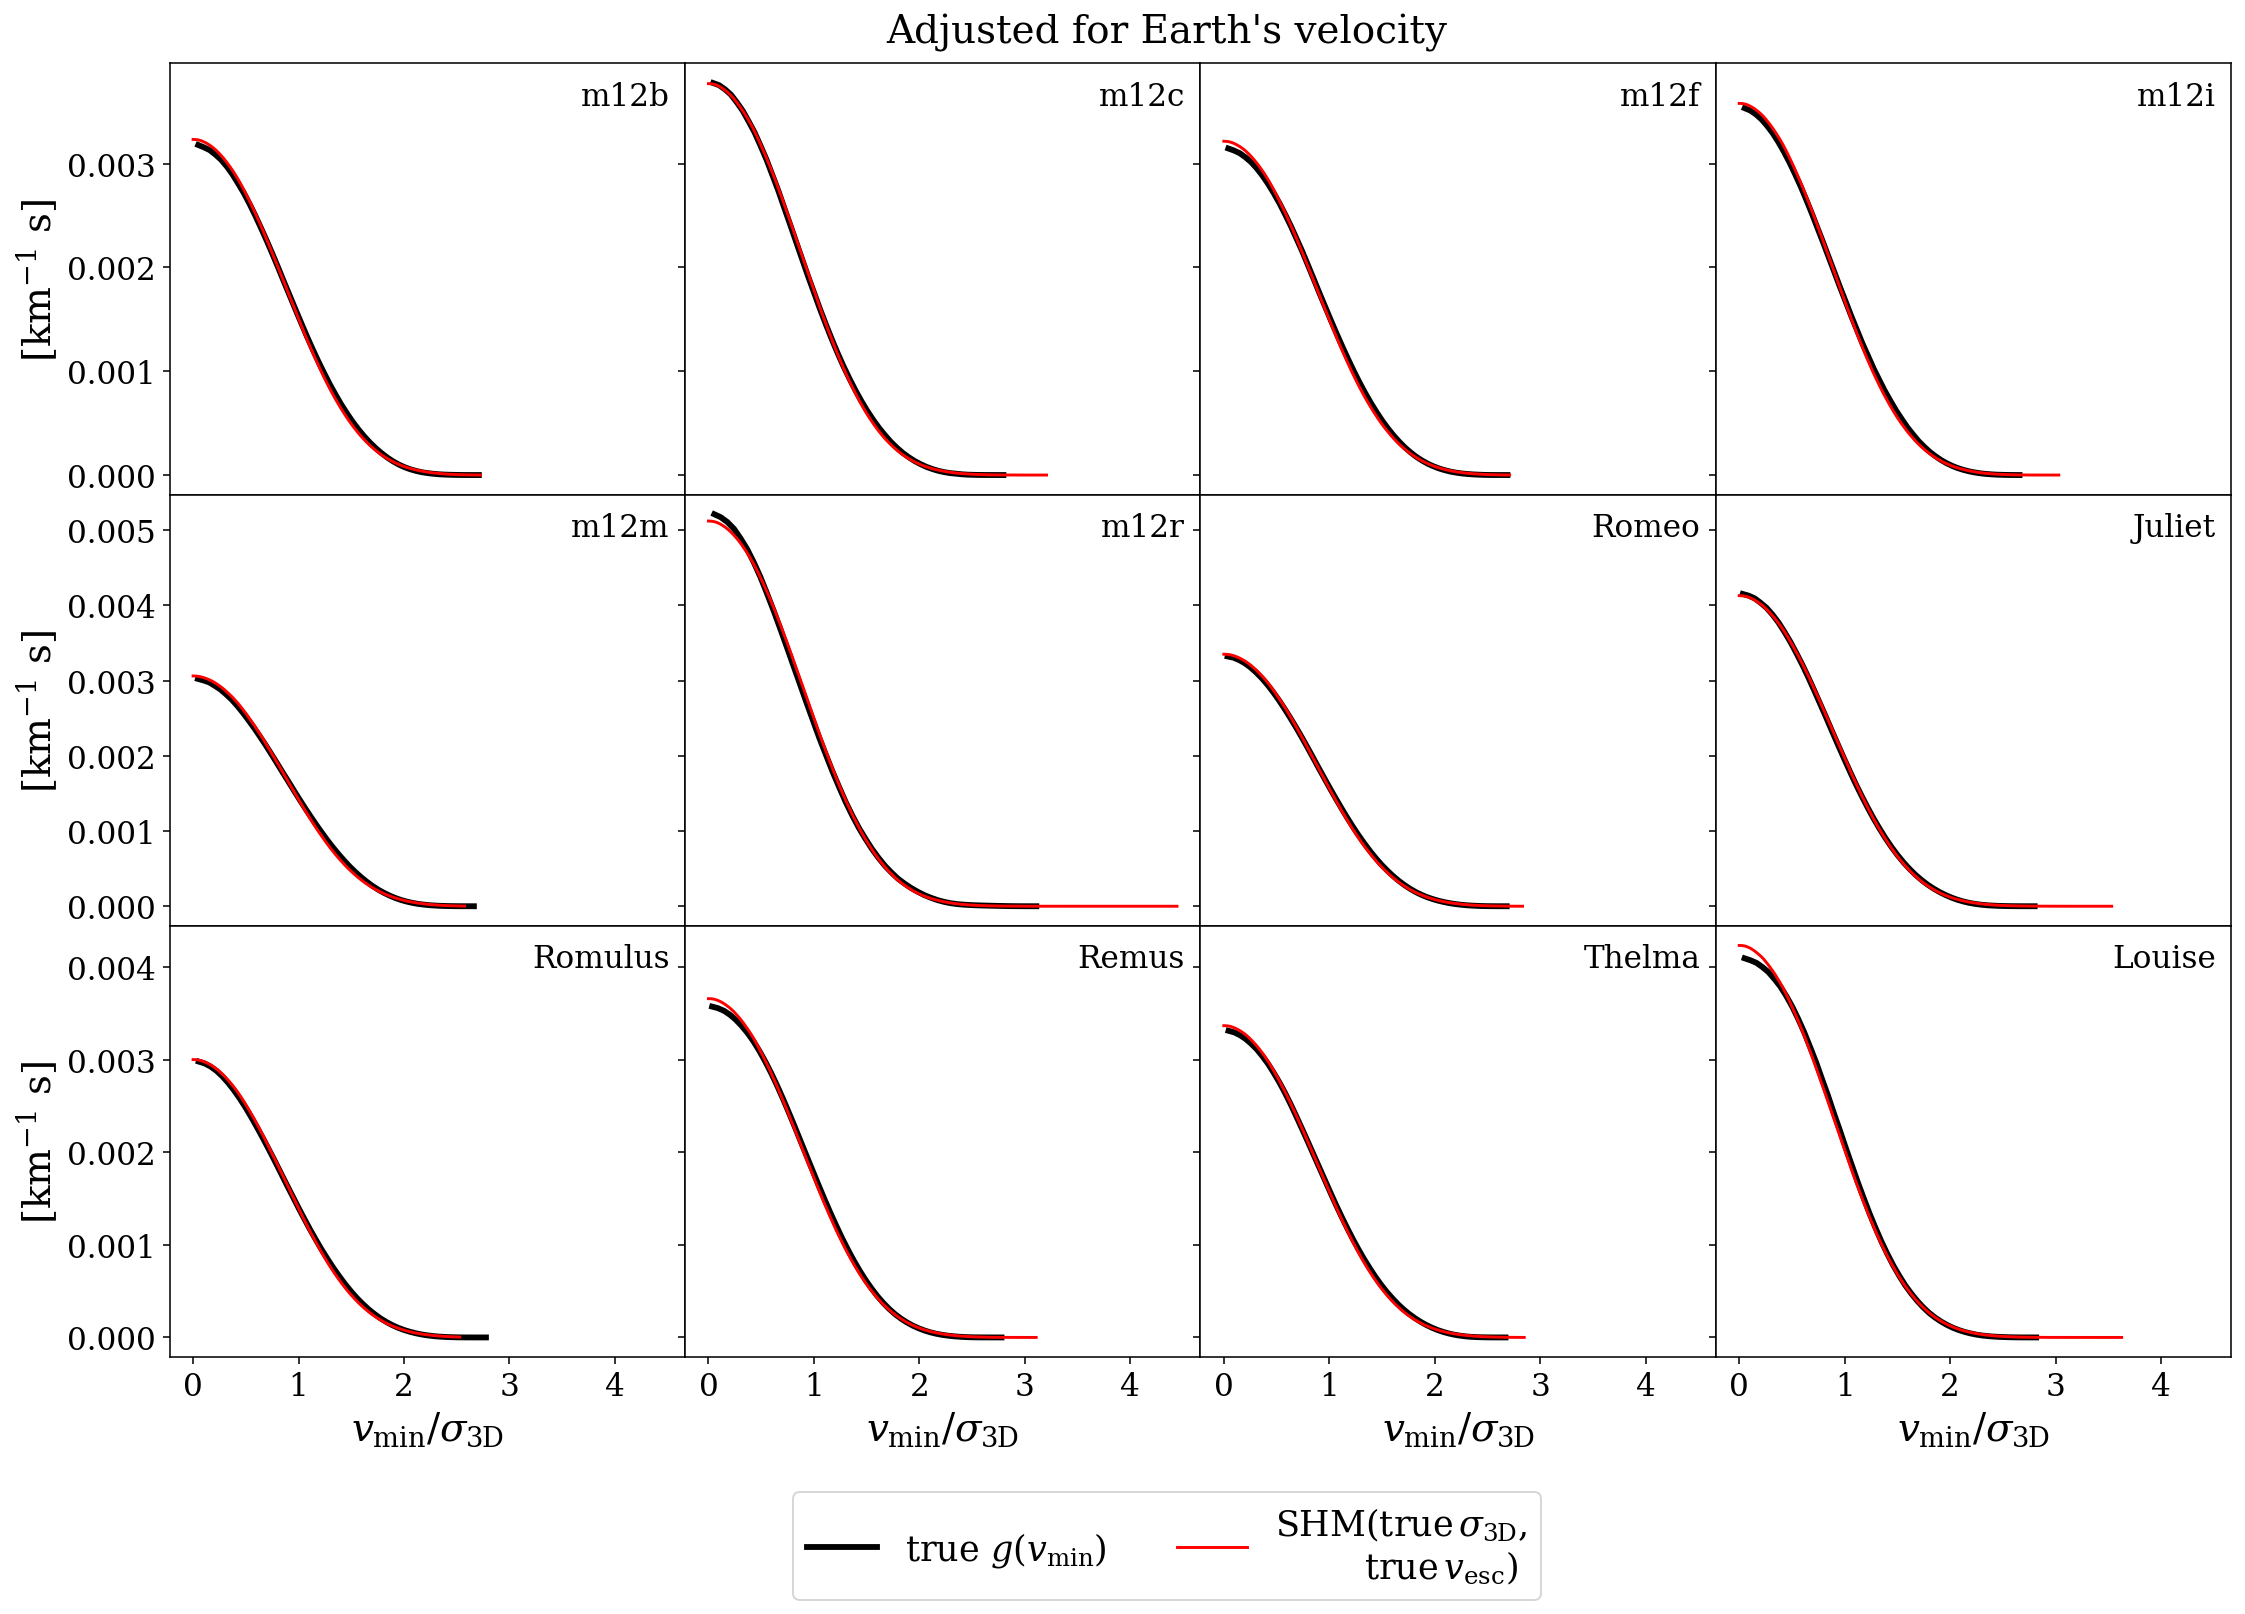

In [35]:
deltas = gen_deltas(True, norm_plots=True)

/tmp/ipykernel_13786/1261919945.py:86: RuntimeWarning: divide by zero encountered in true_divide
  frac_deltas = deltas/g_num


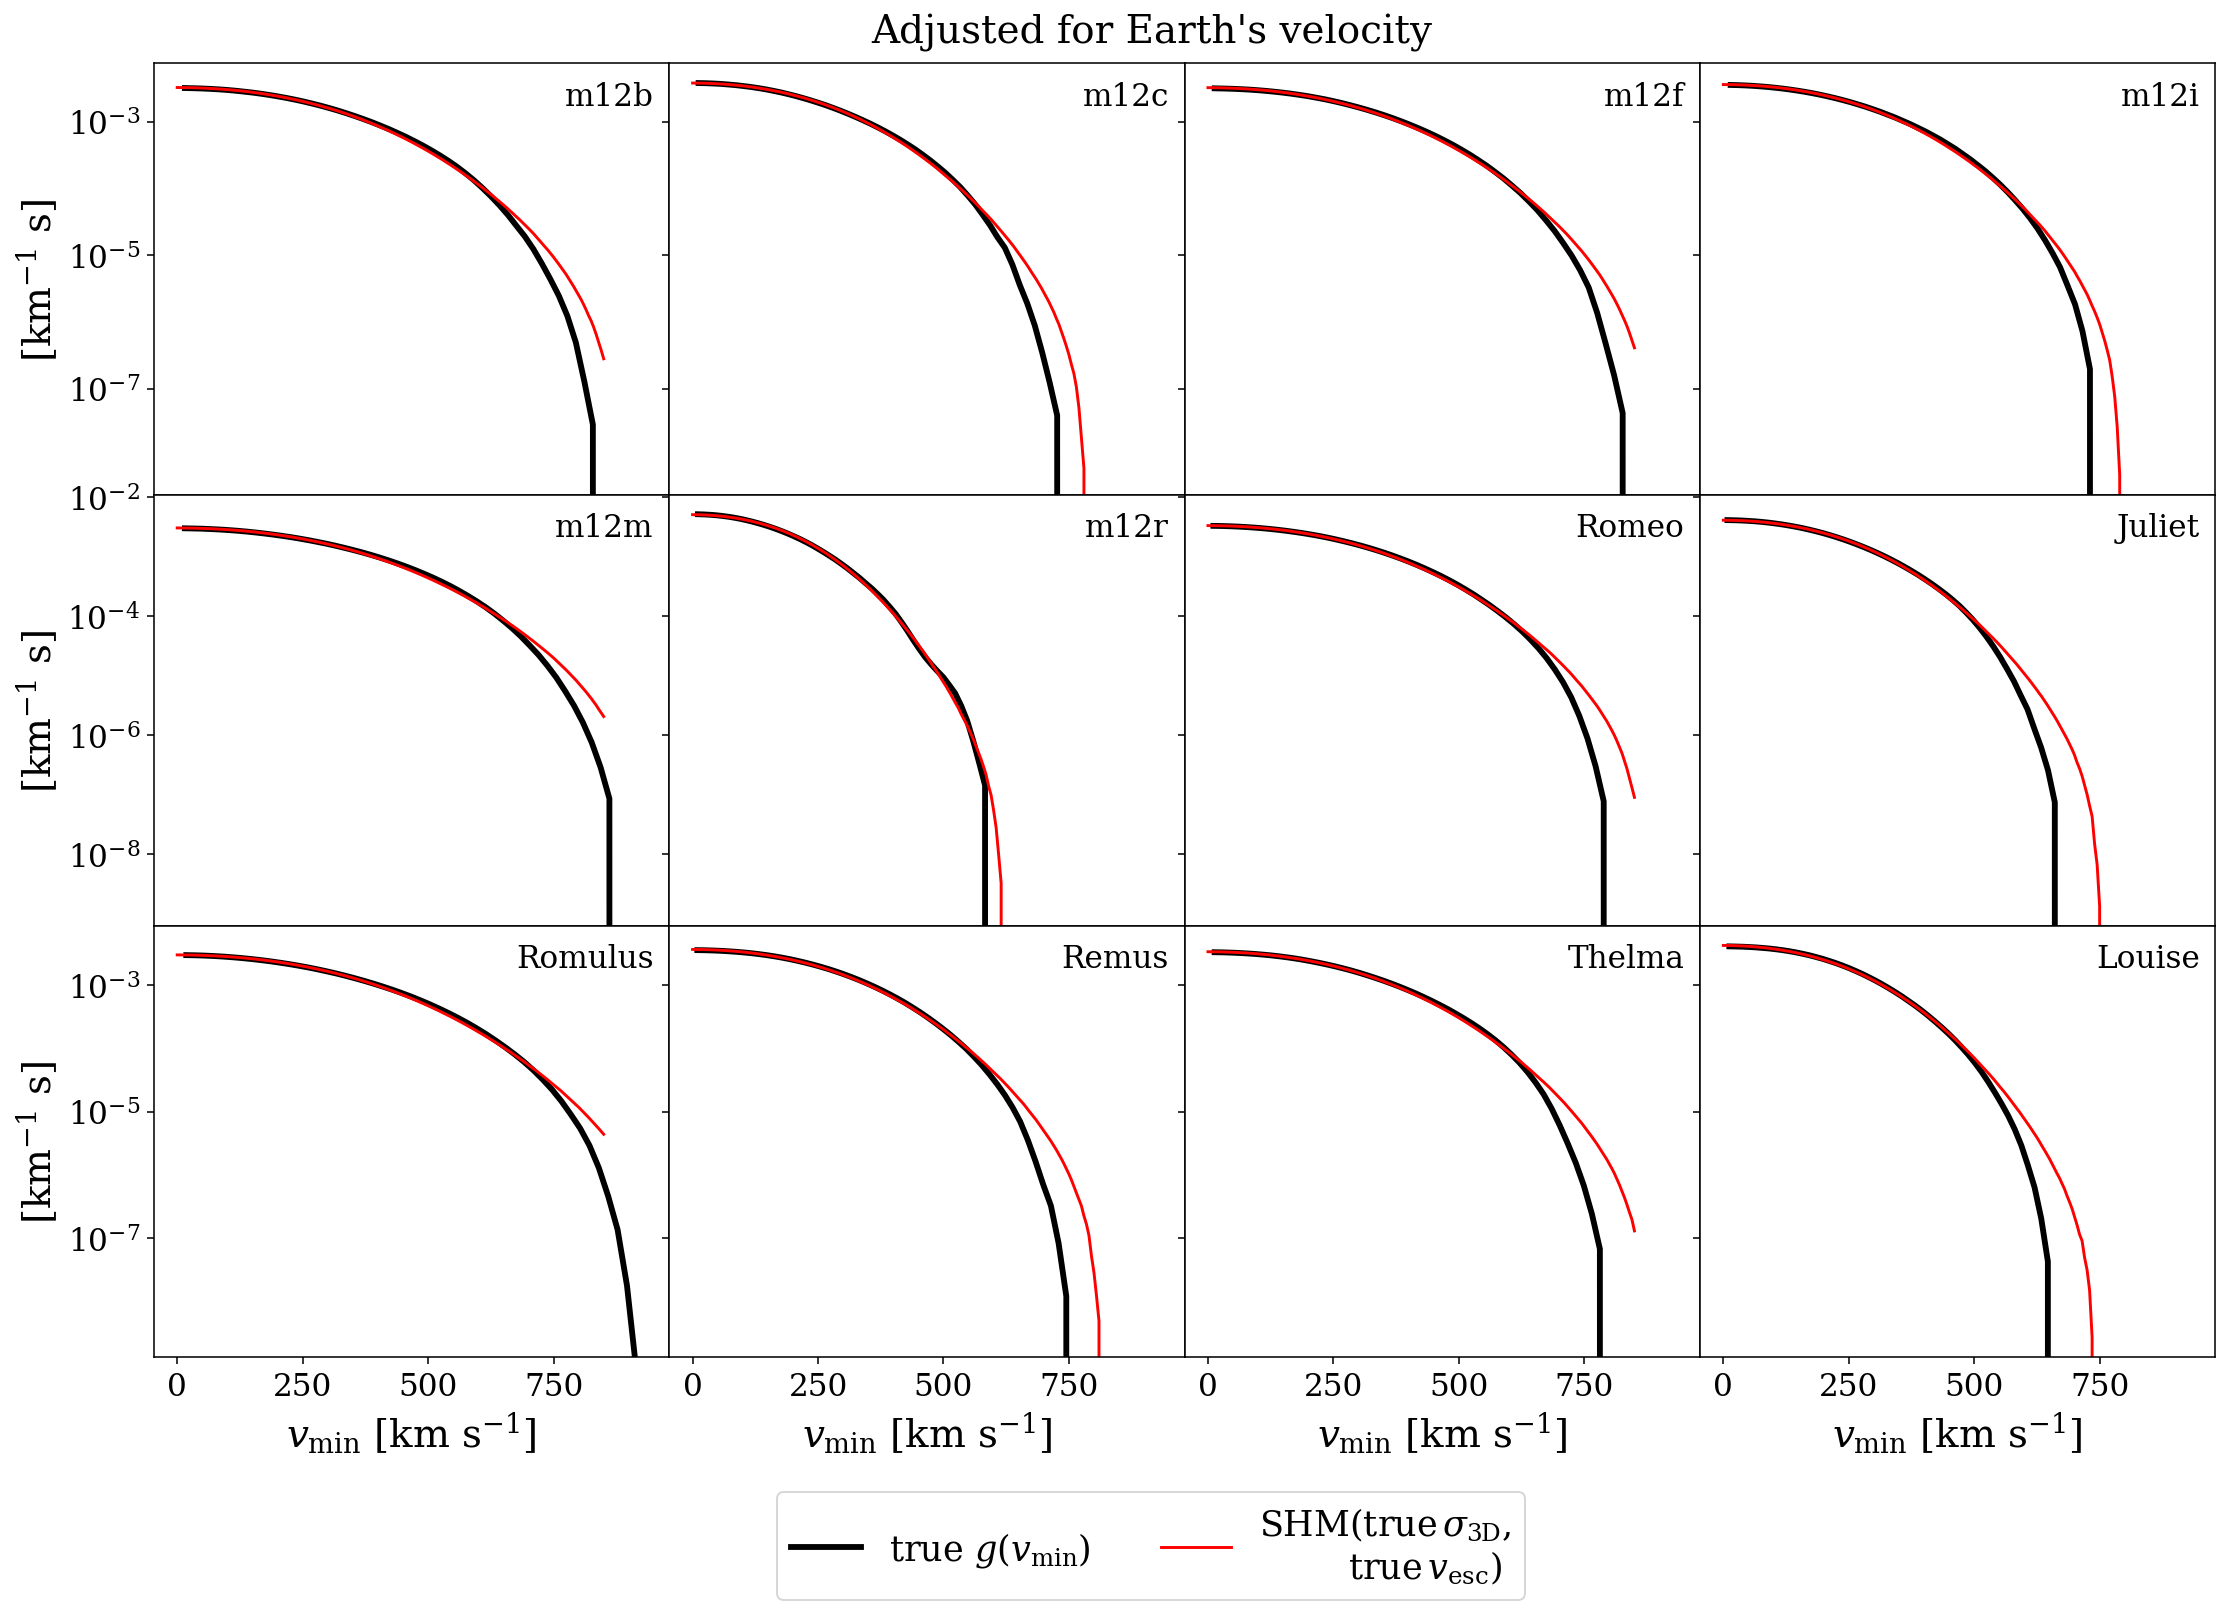

In [9]:
_ = gen_deltas(incl_v_esc=True, norm_plots=False)

/var/folders/94/r7q1ltfd5cdf55qhtt067d380000gn/T/ipykernel_14014/556659488.py:87: RuntimeWarning: divide by zero encountered in true_divide
  frac_deltas = deltas/g_num


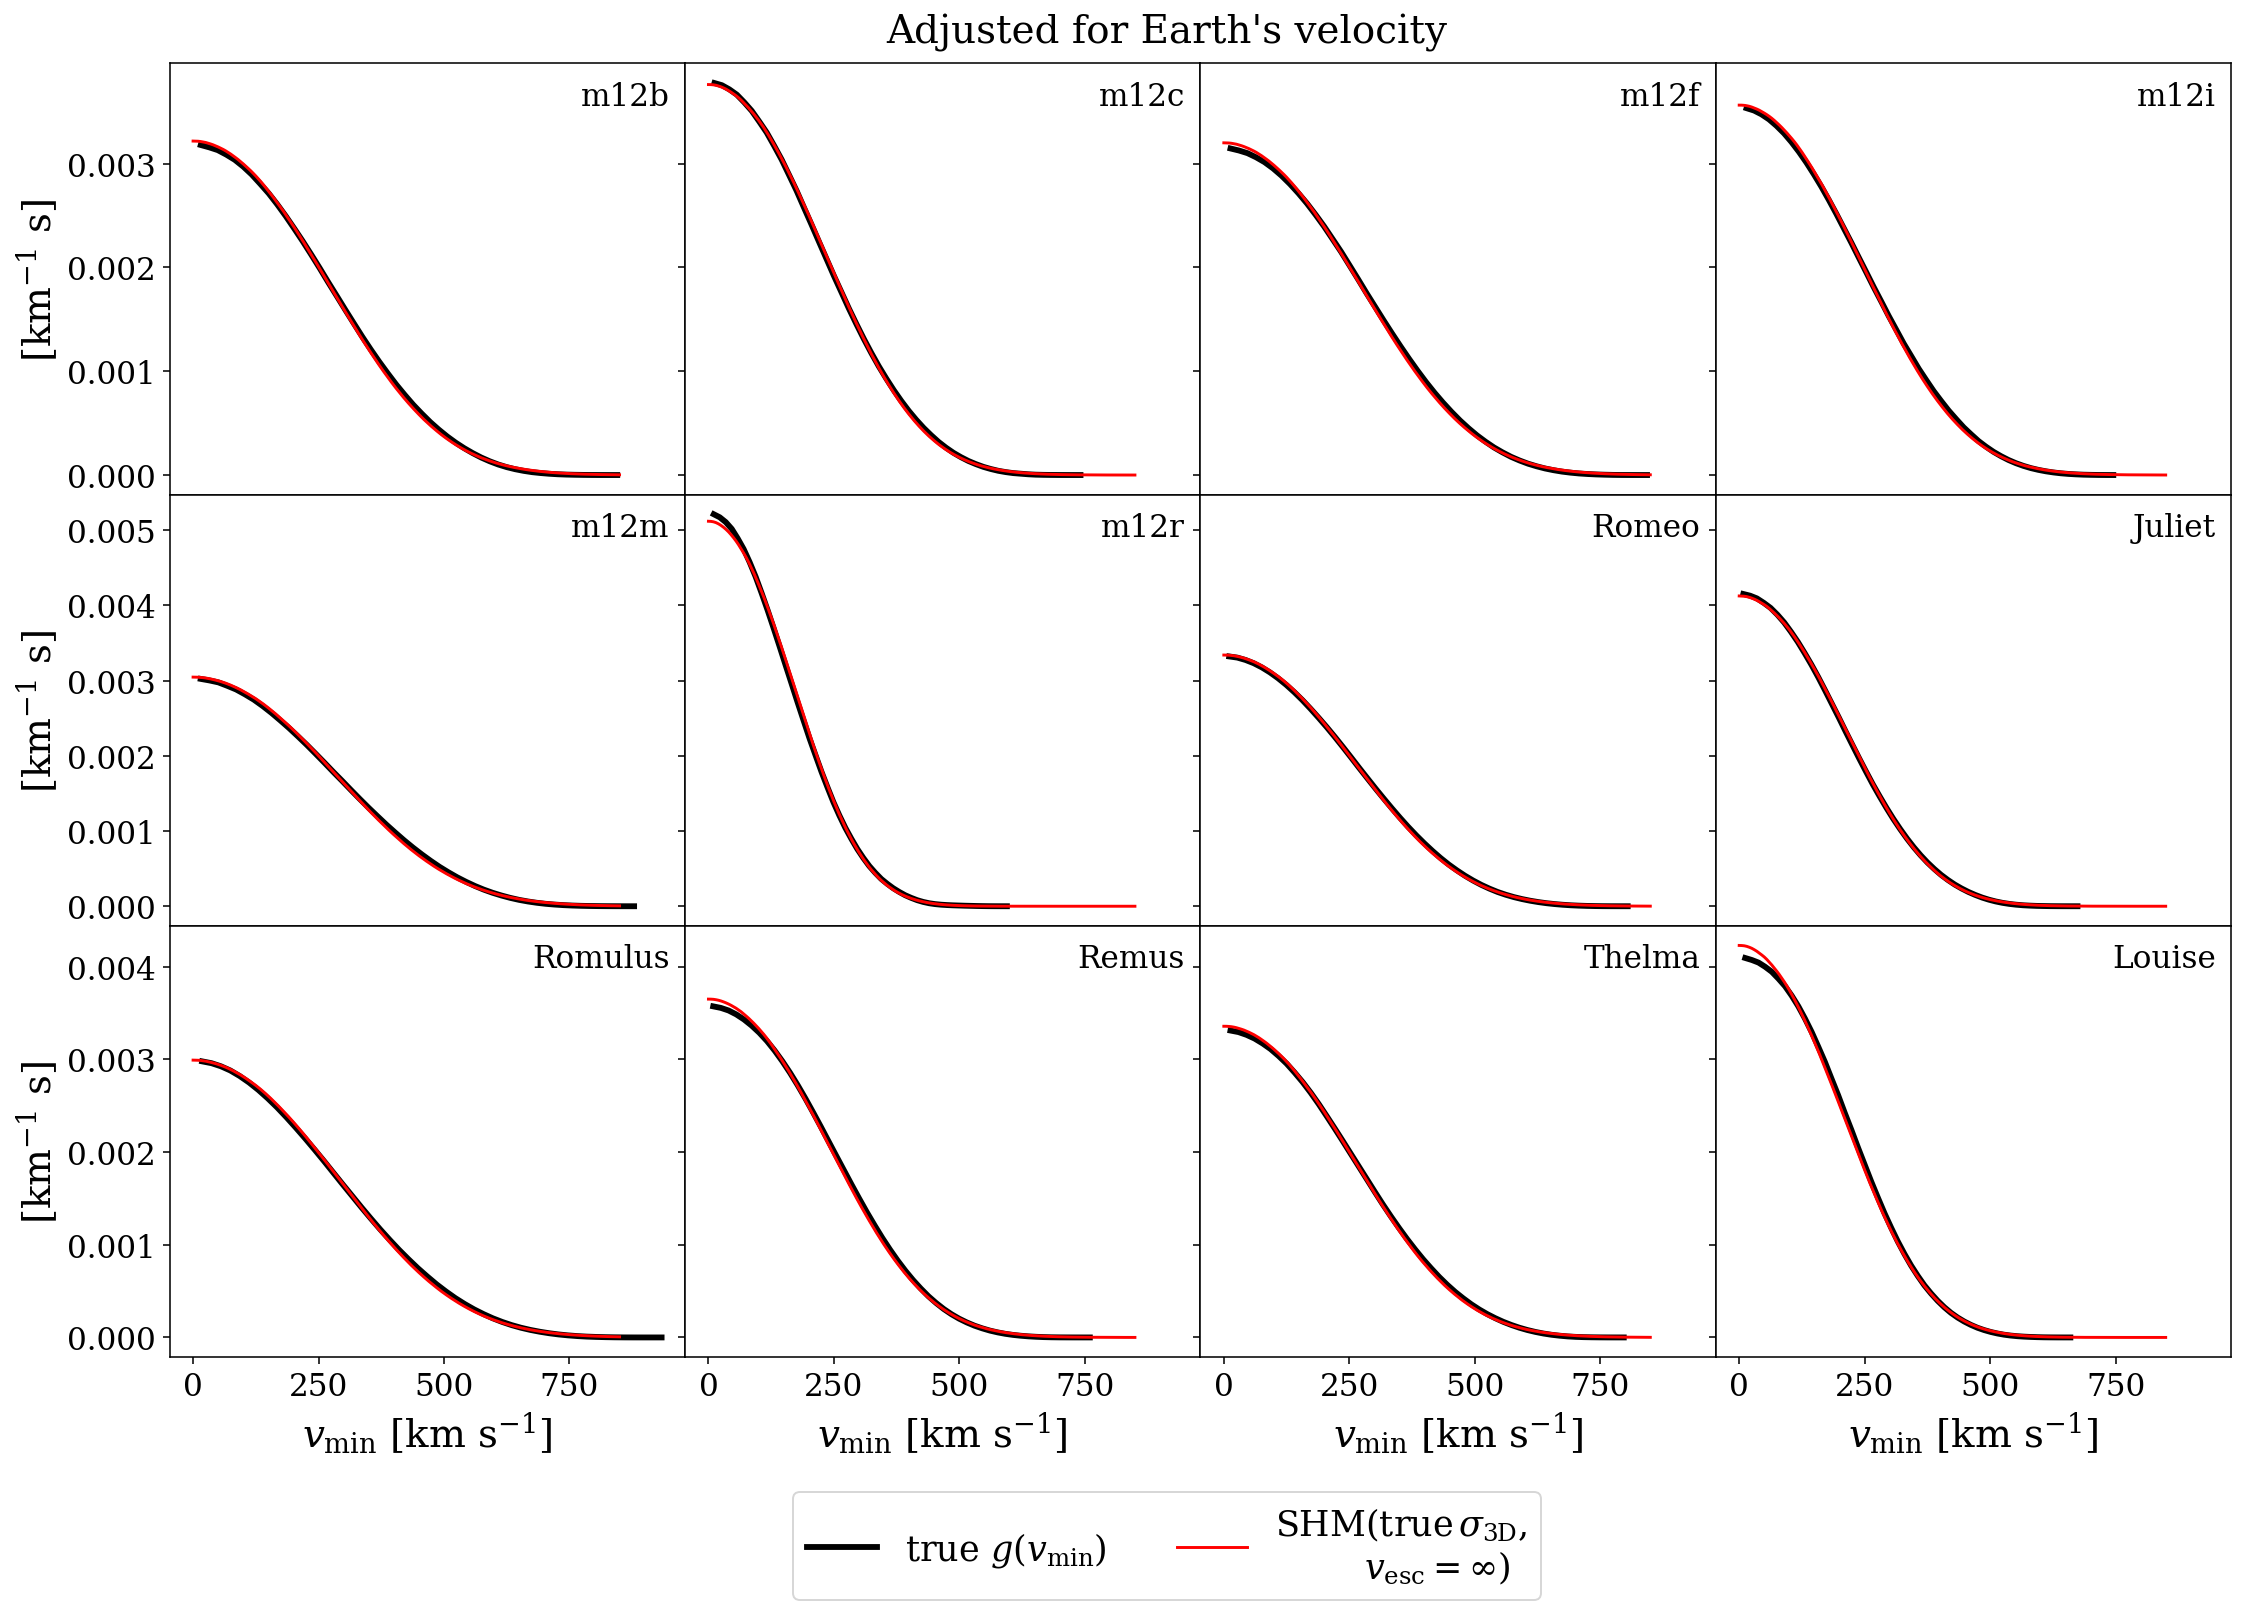

In [37]:
deltas_ex_v_esc = gen_deltas(False)

/var/folders/94/r7q1ltfd5cdf55qhtt067d380000gn/T/ipykernel_14014/556659488.py:87: RuntimeWarning: invalid value encountered in true_divide
  frac_deltas = deltas/g_num


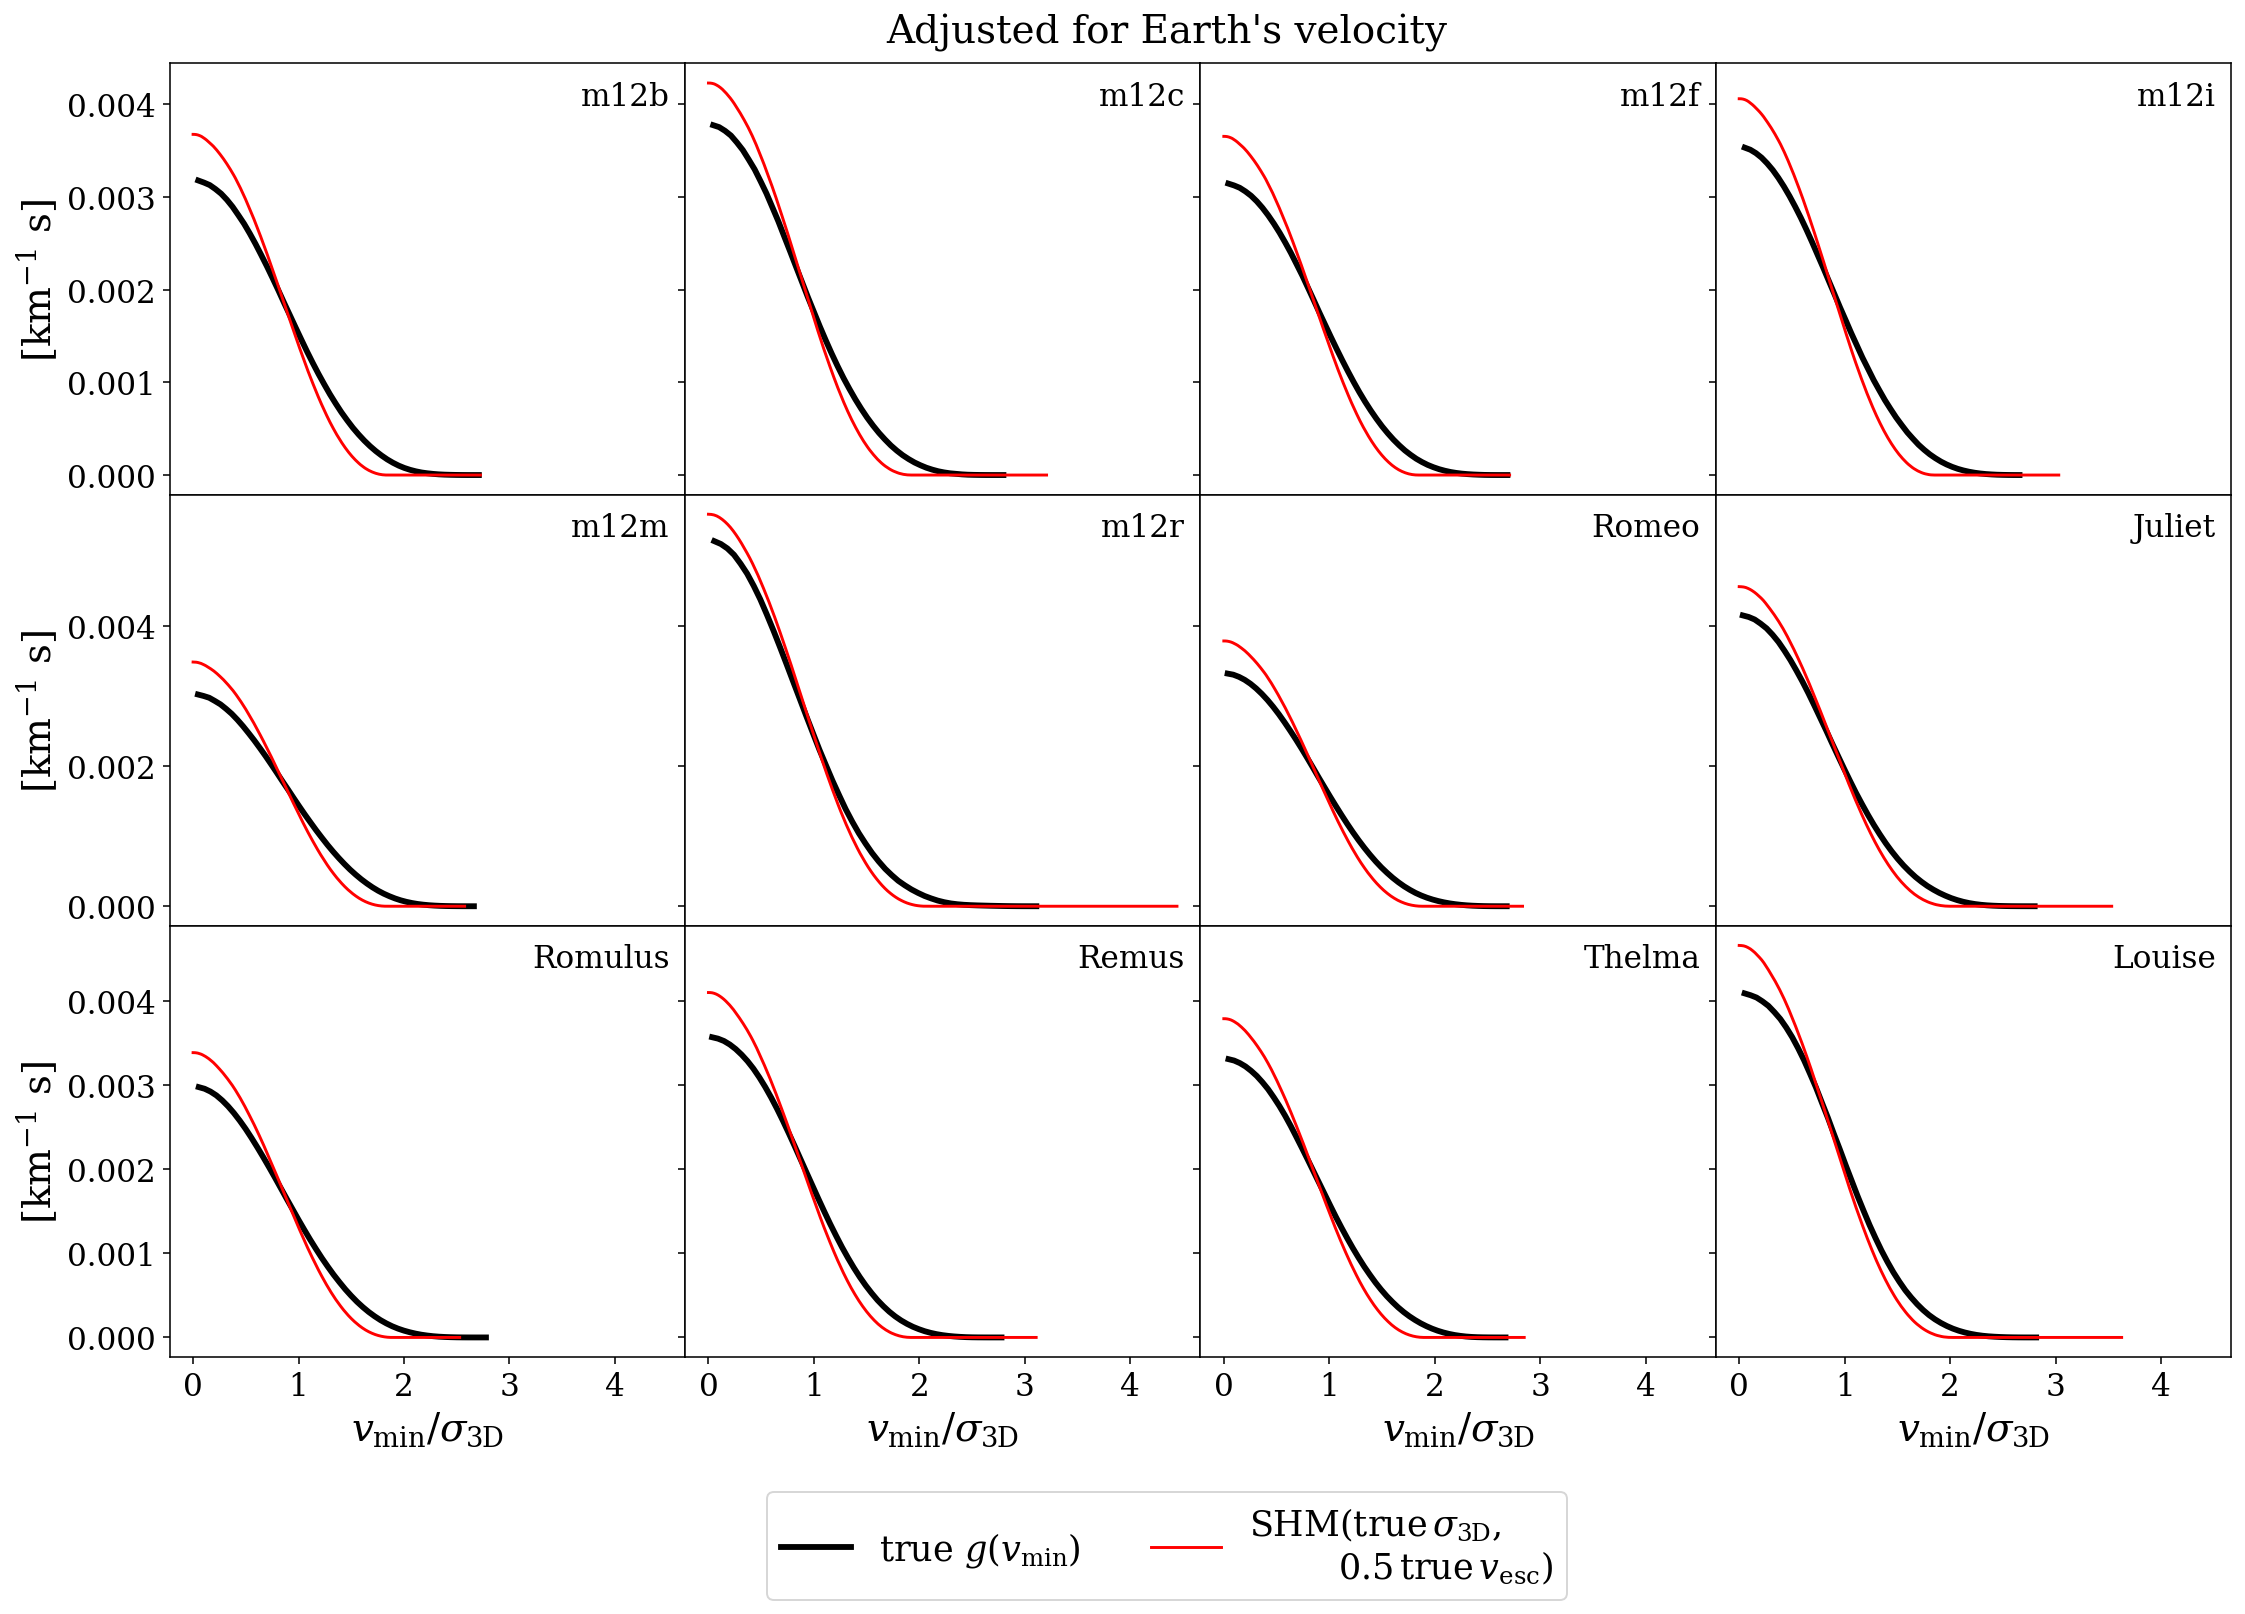

In [38]:
deltas_wrong_v_esc = gen_deltas(True, 1./2., norm_plots=True)

/var/folders/94/r7q1ltfd5cdf55qhtt067d380000gn/T/ipykernel_14014/556659488.py:87: RuntimeWarning: invalid value encountered in true_divide
  frac_deltas = deltas/g_num


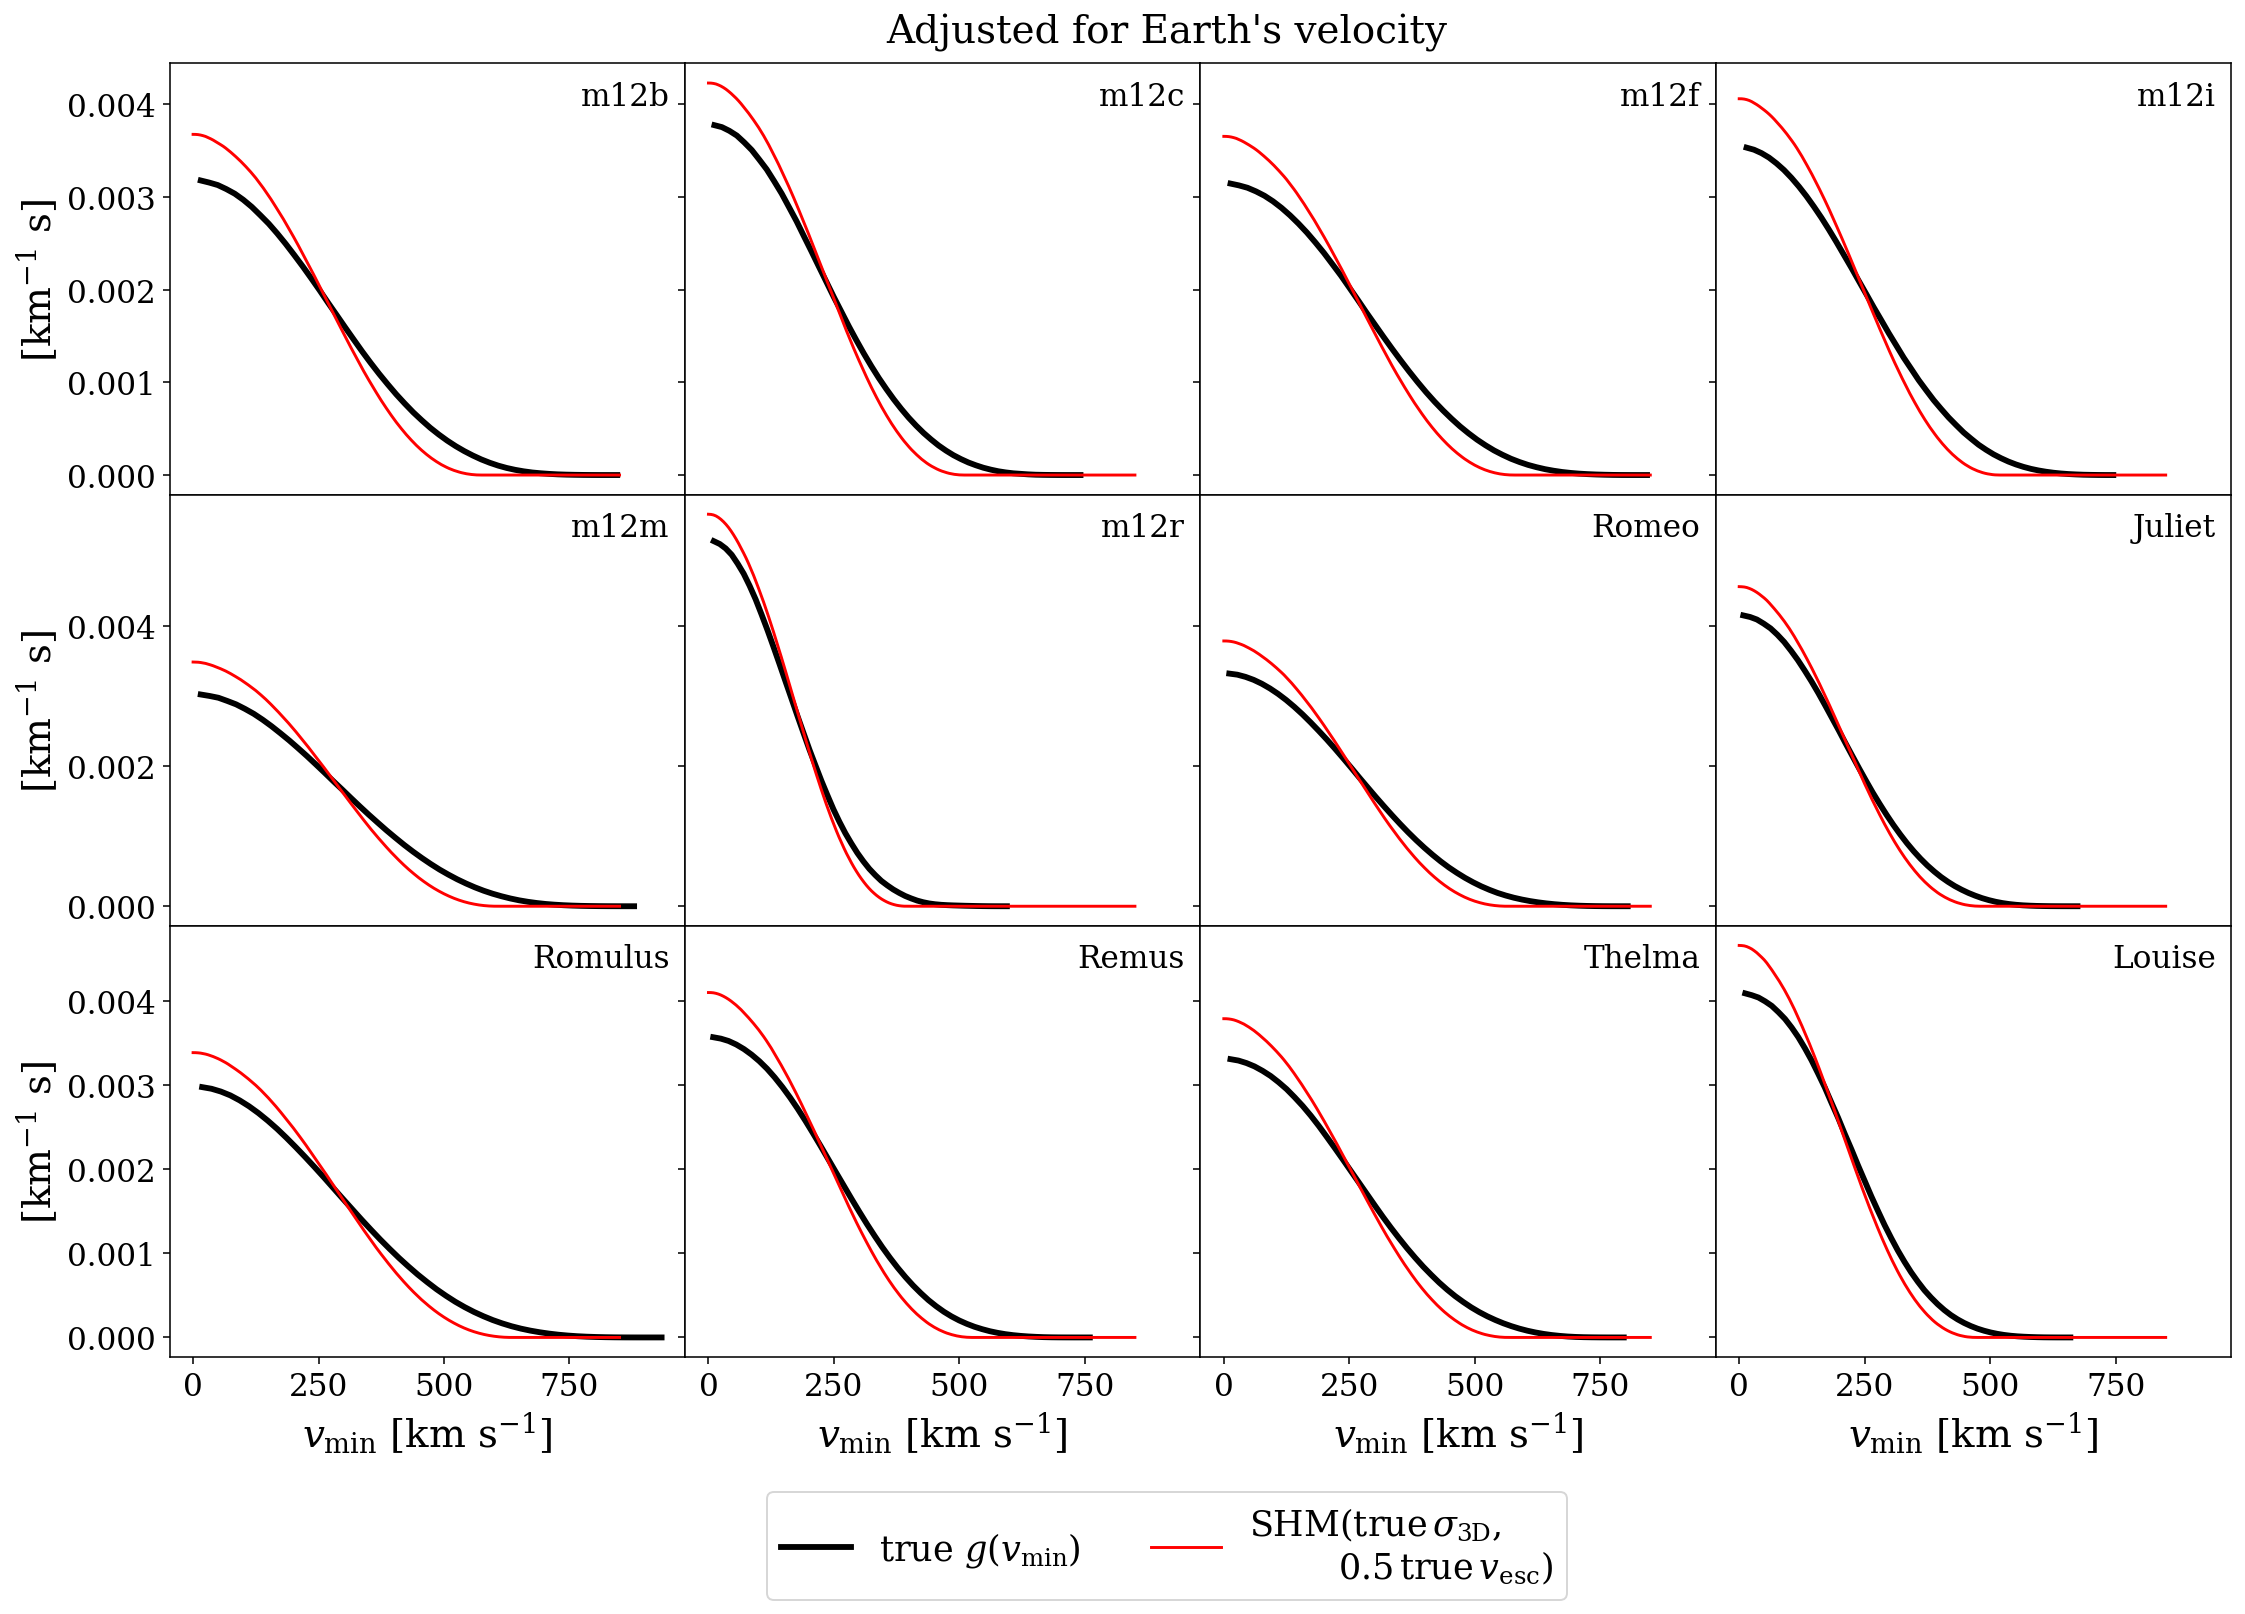

In [39]:
_ = gen_deltas(incl_v_esc=True, v_esc_mult=1./2.) 

### Deltas

In [40]:
def plot_deltas(deltas, ylim_dir=(None,None), ylim_frac=(-0.11,0.12)):
    fig,axs=plt.subplots(2,1,figsize=(7,10),sharex=True,sharey=False)  
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    #direct
    set_colors(axs[0],deltas)
    for gal in deltas:
        axs[0].plot(deltas[gal]['zetas'],deltas[gal]['deltas'],
                label=gal)
    #axs[0].legend(bbox_to_anchor=(1.05,1.), loc='upper left', labelspacing = 1.,
    #          ncol=2)
    axs[0].set_ylabel('$g_\mathrm{SHM} - g_\mathrm{sim}$')
    #axs[0].set_xlabel('$v_\mathrm{min} / \sigma_\mathrm{3D}$')
    axs[0].set_ylim(*ylim_dir)    
    
    #fractional
    set_colors(axs[1],deltas)
    for gal in deltas:
        axs[1].plot(deltas[gal]['zetas'],deltas[gal]['deltas_frac'],
                label=gal)
    #axs[1].legend(bbox_to_anchor=(1.05,1.), loc='upper left', labelspacing = 1.,
    #          ncol=2)
    axs[1].set_ylabel('$\Delta g / g_\mathrm{sim}$')
    axs[1].set_xlabel('$v_\mathrm{min} / \sigma_\mathrm{3D}$')
    axs[1].set_ylim(*ylim_frac)
    
    axs[0].legend(bbox_to_anchor=(.9,0.5),
          bbox_transform=fig.transFigure,
          loc="center left",ncol=1)
    
    plt.draw()
    yticks = axs[1].get_yticks()
    axs[1].set_yticks(yticks[:-1])
    
    axs[1].set_ylim(*ylim_frac)
    
    plt.show()
    
    return None

ylim_dir=(-4.e-4, 6e-4)
ylim_frac_small = (-0.1, 0.1)
ylim_frac=(-1.05, 0.2)

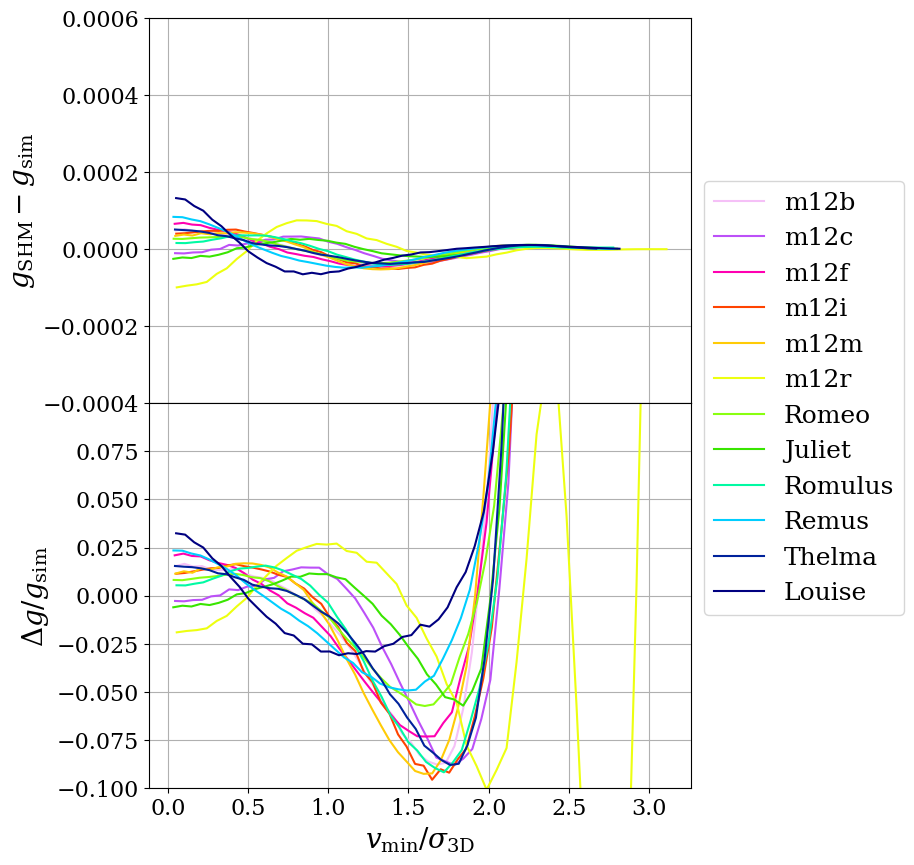

In [41]:
plot_deltas(deltas, ylim_dir=ylim_dir, ylim_frac=ylim_frac_small)

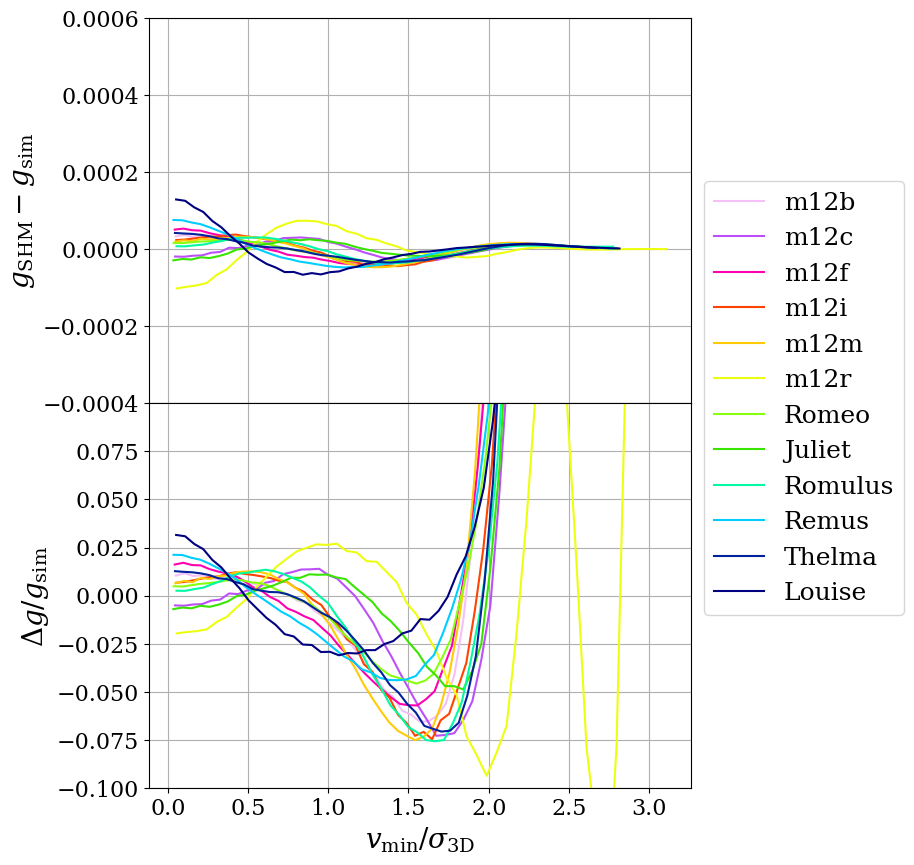

In [42]:
plot_deltas(deltas_ex_v_esc, ylim_dir=ylim_dir, ylim_frac=ylim_frac_small)

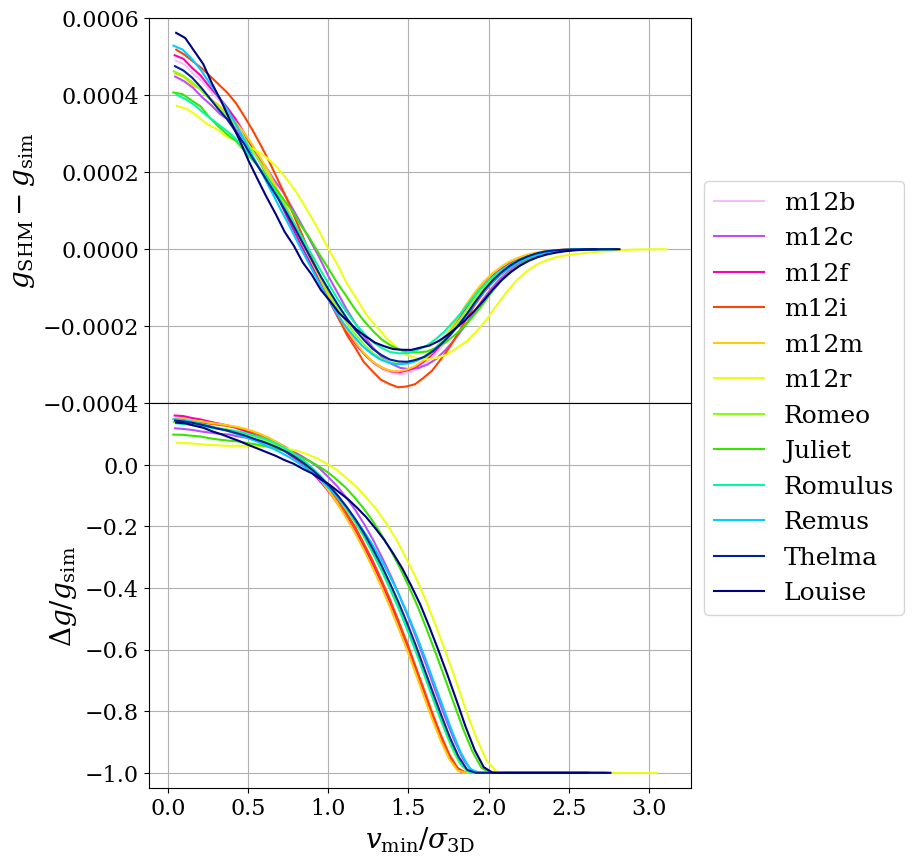

In [43]:
plot_deltas(deltas_wrong_v_esc, ylim_dir=ylim_dir, ylim_frac=ylim_frac)

# Loading data from SHMpp

In [44]:
def pullgvmin(fname):
    folder = '/export/nfs0home/pstaudt/projects/project01/SHMpp/'
    fullname = folder+fname
    xs, ys = np.loadtxt(fullname, unpack=True)
    return xs,ys

zetas_shm, gs_shm = pullgvmin('gvmin_round_mod.dat')
zetas_shmpp, gs_shmpp = pullgvmin('gvmin_SHMpp_mod.dat')
zetas_saus, gs_saus = pullgvmin('gvmin_sausage_mod.dat')
vs_shm_orig, gs_shm_orig = pullgvmin('gvmin_round.dat')
vs_shmpp_orig, gs_shmpp_orig = pullgvmin('gvmin_SHMpp.dat')
vs_saus_orig, gs_saus_orig = pullgvmin('gvmin_sausage.dat')
vs_shm_rec, gs_shm_rec = pullgvmin('gvmin_round_reconcile.dat')
vs_shmpp_rec, gs_shmpp_rec = pullgvmin('gvmin_SHMpp_reconcile.dat')
vs_saus_rec, gs_saus_rec = pullgvmin('gvmin_sausage_reconcile.dat')

FileNotFoundError: /export/nfs0home/pstaudt/projects/project01/SHMpp/gvmin_round_mod.dat not found.

# Plotting normalized $g$

In [ ]:
def zetas_gs_gal(galname):
    vbins = pdfs_v[galname]['bins']
    
    sigma=sigmas[galname] 
    zeta_bins = vbins / sigma
    
    ps = pdfs_v[galname]['ps']
    ps = ps * sigma
    
    dzetas=zeta_bins[1:]-zeta_bins[:-1]
    dzeta = np.mean(dzetas)
    zetas=(zeta_bins[1:]+zeta_bins[:-1])/2.

    integrand =  ps / zetas
    g_num = [scipy.integrate.simps(integrand[i:],zetas[i:]) 
             for i in range(len(integrand))]
    return zetas, g_num

def evans_compare_normd():
    #zetas, g_num = zetas_gs_gal(galname)
   
    zetas_for_func = np.linspace(0.,2.1,100)
    
    # Another way of doing the following 2 functions probably would have been to
    # calculate g(vmin) regularly and then just transform zeta = vmin/v0. I 
    # *think* no matter what v0 we choose, g(zeta) would look the same for any 
    # choice of v0. I have not tested this.
    def g_integrand(zeta):
        # N normalizes so that int_0^infty f(zeta) 4pi zeta^2 dzeta = 1
        N = np.pi**(3./2.)
        f = 1./N * np.exp(-zeta**2.)
        jacobian = 4.*np.pi*zeta**2.
        return  jacobian * f/zeta
    def g_f(zeta_min):
        listlike = (list, tuple, set, np.ndarray)
        if isinstance(zeta_min, listlike):
            g = [scipy.integrate.quad(g_integrand, z, np.inf)[0] 
                 for z in zeta_min]
            g = np.array(g)
        else:
            g = scipy.integrate.quad(g_integrand, zeta_min, np.inf)[0]
        return g

    fig=plt.figure(figsize=(7,5))
    ax=fig.add_subplot(111)
    
    ax.plot(zetas_for_func, g_f(zetas_for_func), '--r', lw=2.5,
            label='SHM')
    ax.plot(zetas_shm, gs_shm, ':b', lw=2.5, label='SHM (from github)')
    ax.plot(zetas_shmpp, gs_shmpp, '-b', lw=2.5, label='SHM++')
    
    deltas={}    
    set_colors(ax,pdfs_v)
    for galname in pdfs_v:
        zetas_gal, gs_gal = zetas_gs_gal(galname)
        ax.plot(zetas_gal, gs_gal)
        deltas[galname]={}
        deltas[galname]['zetas']=zetas_gal
        deltas[galname]['deltas'] = gs_gal - g_f(zetas_gal)
    
    ax.set_xlabel('$\zeta_\mathrm{min}$')
    ax.set_ylabel('$g(\zeta_\mathrm{min})$')
    ax.legend(bbox_to_anchor=(0.98,0.98), loc='upper right')
    fig.patch.set_facecolor('white')

    plt.show()

    return deltas

deltas = evans_compare_normd()

fig = plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
set_colors(ax,deltas)
for gal in deltas:
    ax.plot(deltas[gal]['zetas'],deltas[gal]['deltas'],
            label=gal)
ax.legend(bbox_to_anchor=(1.05,1.), loc='upper left', labelspacing = 1.,
          ncol=2)
ax.set_ylabel('$\int_{{\zeta_\mathrm{{min}}}}^\infty\\dfrac{{p(\zeta_\mathrm{{min}})}}'
              '{{\zeta}}\mathrm{{d}}\zeta - g(\zeta_\mathrm{min})$')
ax.set_xlabel('$\zeta_\mathrm{min}$')
plt.show()

# Plotting data from SHMpp

## Using updated parameters on both SHM and SHM++

In [ ]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(vs_shm_orig, gs_shm_orig, 'r--', label='SHM')
ax.plot(vs_shmpp_orig, gs_shmpp_orig, 'b-', label='SHM++')
ax.plot(vs_saus_orig, 0.2*gs_saus_orig, 'b--', label='20% sausage')
ax.plot(vs_saus_orig, gs_saus_orig, 'b:', label='sausage')
ax.legend()
ax.set_ylim(0.,4.e-3)
ax.set_ylabel('$g(v_\mathrm{min})$ [km$^{-1}\,$s]')
ax.set_xlabel('$v_\mathrm{min}$ [km$\,$s$^{-1}$]')
plt.show()

## Using original parmeters on both the SHM and SHM++ model
This again shows that the two models are not far off from each other. The difference in Evans et al. 2019 is the difference between using SHM from this plot (original parameters) vs SHM++ from the plot above (updated parameters).

In [ ]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(vs_shm_rec, gs_shm_rec, 'r--', label='SHM')
ax.plot(vs_shmpp_rec, gs_shmpp_rec, 'b-', label='SHM++')
ax.plot(vs_saus_rec, 0.2*gs_saus_rec, 'b--', label='20% sausage')
ax.plot(vs_saus_rec, gs_saus_rec, 'b:', label='sausage')
ax.legend()
ax.set_ylim(0.,4.e-3)
ax.set_ylabel('$g(v_\mathrm{min})$ [km$^{-1}\,$s]')
ax.set_xlabel('$v_\mathrm{min}$ [km$\,$s$^{-1}$]')
plt.show()

## $g(\zeta)$
I think I generated this by setting $v_0=1$ and $v_\mathrm{esc}=\infty$.

In [ ]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(zetas_shm, gs_shm, 'r--', label='SHM')
ax.plot(zetas_shmpp, gs_shmpp, 'b-', label='SHM++')
ax.plot(zetas_saus, 0.2*gs_saus, 'b--', label='20% sausage')
ax.plot(zetas_saus, gs_saus, 'b:', label='sausage')
ax.legend()
#ax.set_ylim(0.,4.e-3)
ax.set_ylabel('$g(\zeta_\mathrm{min})$')
ax.set_xlabel('$\zeta$')
plt.show()